In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sc
import scipy.ndimage as scimg
from scipy.optimize import minimize
import psana as ps
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter as gf

from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d
import sys
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
import scipy.misc as scmis
from scipy.optimize import curve_fit
import scipy.special as sp
import cv2

from datetime import datetime
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
from recon_funcs import *


/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/gData.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if gData['rBF'] is not 'custom':


Hi! I imported. 


In [4]:
mfn = 25
gfn = 15
gfsig = 0.985
basesdir = '/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/'
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5')

In [6]:
! ls '/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/'

alpha_tdata.npy       Bpbasis_Up_0.1eV.npy  Bpbasis_Up_0_to_0.5eV_filtered.npy
alpha_t.npy	      Bpbasis_Up_0.2eV.npy  tdata.npy
alpha_t_sample.npy    Bpbasis_Up_0.3eV.npy  vNaxis_t.npy
basis_all.mat	      Bpbasis_Up_0.4eV.npy  vNaxis_t_sample.npy
Bpbasis_Up_0.0eV.npy  Bpbasis_Up_0.5eV.h5   vNaxis_w.npy
Bpbasis_Up_0.1eV.h5   Bpbasis_Up_0.5eV.npy


In [12]:
gfsig = 0 
Ups = [0.0]
Bps = []
alphas = []
vNaxiss = []
alphaws = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    filename = 'Bpbasis_Up_' + str(Up)+'eV.npy'
    print(filename)
    BB = np.load(basesdir+filename, allow_pickle=True)
    
    Breal = np.real(BB)
    Bimag = np.imag(BB)
    alpha_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/alpha_t_sample.npy')
    vNaxis_t=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t.npy')
    vNaxis_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t_sample.npy')
    vNaxis_w=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_w.npy')
    
    br = np.array({'Breal':Breal, 'Bimag': Bimag, 'vNaxis': {'t':vNaxis_t, 't_sample':vNaxis_t_sample, 'w':vNaxis_w}, 'alpha': {'t_sample':alpha_t_sample}})
   
    
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    #breal = br[()]['breal']
    #bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    if Breal.shape[0] == 128**2:
        tempr = np.zeros((Breal.shape[0], 64**2))
        tempi = np.zeros((Breal.shape[0], 64**2))
        for i in range(len(Breal)):
            tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
            tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

        Breal = tempr
        Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        alphw[i] = np.fft.ifftshift(np.fft.ifft(alpha['t_sample'][i]))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)

Bpbasis_Up_0.0eV.npy


/tmp/ipykernel_26209/2473570407.py:54: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
/tmp/ipykernel_26209/2473570407.py:61: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))


In [13]:
from scipy.optimize import minimize

def make_MM(x0):
    xshift, yshift =  x0[8], x0[9] 

    # Coordinates that you want to Perspective Transform
    pts1 = np.float32([[0,0],\
                       [0,1024],\
                       [1024,0],\
                       [1024, 1024]])


    # Size of the Transformed Image
    pts2 = np.float32([[0+xshift-x0[0],0 + yshift-x0[1]],\
                       [0+xshift-x0[2],1024 + yshift-x0[3]],\
                       [1024+xshift-x0[4],0 + yshift-x0[5]],\
                       [1024+xshift-x0[6],1024 + yshift-x0[7]]])

    MM = cv2.getPerspectiveTransform(pts1,pts2)
    return MM

#mask to block bright spots by the hole
x,y, = 530,512
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-x)**2+(Y-y)**2)
mask=np.zeros((1024,1024))
mask[rs>1*48]=1

In [14]:
MM = make_MM([0,0, 0, 0, 0, 0, 0, 0, 512-535, 512-512])


In [29]:
run.detnames

{'andor',
 'ebeam',
 'epicsinfo',
 'gmd',
 'pcav',
 'timing',
 'tmo_atmopal',
 'tmo_opal1',
 'tmo_opal2',
 'xgmd'}

In [44]:
#tmoc00118, run 286, 289
exp = 'tmoc00118'
runnum = 286 
gmd_min = 0.05
gmd_max = 0.5
gas_jet = 1



In [73]:
nn = 0
ds = ps.DataSource(exp=exp, run=runnum)
run = next(ds.runs())

if hasattr(run, 'epicsinfo'):
    epics_strs = [item[0] for item in run.epicsinfo.keys()][1:] # first one is weird
    epics_detectors = [run.Detector(item) for item in epics_strs]    


# specify detectors here
opal1 = run.Detector('tmo_opal1') # OPAL camera looking at the holey mirror
gmd = run.Detector("gmd") # gas intensity detector 
xgmd = run.Detector("xgmd") # gas intensity detector 
timing = run.Detector('timing') # this gives access to evr codes
ebeam = run.Detector("ebeam")
#spectrometer = run.Detector('tmo_fzpopal') 
spectrometer = run.Detector('andor')



ims_bg = [] # initialize the list of example images here
GDs_bg = []
xGDs_bg = []
specs = []
jet_timing_bg = []


for nevent, event in enumerate(run.events()): # loop over events (shots) in the run

    # fetch the information from the different events
    opal1im_i=np.copy(opal1.raw.raw(event))
    #opal1im_i=np.copy(opal1.raw.image(event)) #doesn't work since update
    gd_i=gmd.raw.energy(event)
    xgd_i=xgmd.raw.energy(event)
    evr=timing.raw.eventcodes(event)
    L3 = ebeam.raw.ebeamL3Energy(event)

    # identify relevant event codes
    gas=evr[70] # did the gas jet fire
    ir_timed=evr[67] # was the ir laser timed
    ir_misttimed=evr[68] # was the ir laser mis-timed

    
    #if opal1im_i is None or gd_i is None or gd_i<gmd_min or (gas != gas_jet): continue
    if opal1im_i is None or gd_i is None or gd_i>gmd_max or gd_i<gmd_min or (gas != gas_jet): continue
    
    data = {'epics_'+epic_str: epic_det(event) for epic_str, epic_det in zip(epics_strs, epics_detectors)}        
    if any(type(val) not in [int, float] for val in data.values()):
        print("Bad EPICS: %d" % nevent)
        #Nbad += 1
        continue
        
        
    if ir_misttimed:
        ims = np.rot90(opal1im_i*mask)
        #ims = ims/np.sum(ims)
        #ims = cv2.warpPerspective(ims,MM,(1024,1024))
        #ims_bg.append(ims[100:900,100:900])
        ims_bg.append(ims)
        GDs_bg.append(gd_i)
        xGDs_bg.append(xgd_i)
        jet_timing_bg.append(data['epics_evr_ch0_delay'])
        
        if spectrometer._det_name == 'andor': #if vls
            spec = np.squeeze(np.copy(spectrometer.raw.value(event)))[:1024]
            spec = np.squeeze(fastsmooth1(spec,20))
            spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[0:100])) 
            spec[spec<0] = 0
            specs.append(spec)
        else: #if zone plate spec
            opalfz= np.copy(spectrometer.raw.image(event)) #np.copy(opal1.raw.image(event)) #np.copy(opal1.raw.raw(event))
            zps_data = opalfz
            zps_pixel = 100+np.argmax(np.sum(zps_data[100:900],axis=1))
            px_2d_width = 25 #spacing to cut the 2d image slice to store. Typically 50 pixel width. 25 on either side
            px_edge_width = 5 #spacing to integrate for the line out. 

            zps_2d = zps_data[zps_pixel-px_2d_width:zps_pixel+px_2d_width][:]
            zps = zps_data[zps_pixel-px_edge_width:zps_pixel+px_edge_width][:].mean(0)#
            zps_bg = zps_data[zps_pixel-px_2d_width:zps_pixel-px_2d_width+px_edge_width][:].mean(0)#
            zps = zps-zps_bg
            spec = np.squeeze(fastsmooth1(zps,10))
            spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[800:900])) 
            spec[spec<0] = 0
            specs.append(spec)
        
        
        nn +=1
        
        
    

    if nn%20 == 0:
        print('gathered: %1.0f' %nn)
        
    if len(ims_bg) > 20:
        break
        

Bad EPICS: 4
Bad EPICS: 5
gathered: 0
gathered: 20
gathered: 20
gathered: 20
gathered: 20
gathered: 20
gathered: 20


In [59]:
def px_2_nm(pixel, vls_pitch, order):
    'updated May 8/9 from Dougie'
    pitch_slope = -1.37220068e+03 # negative of pitch shift to px shift proportionality constant
    pitch_0 = 4.98 #The VLS pitch where the calibration is done 
    order_0 = 4
    pitch_diff = pitch_0-vls_pitch
    effective_pixel = pixel + (pitch_slope*pitch_diff)
    # Result of calibration at pitch_0
    #offset, slope = [ 2.37772901e+00, -3.64235449e-04]
    offset, slope, slope_2 =[ 2.38324323e+00, -3.92516982e-04,  1.44317419e-08]
    return (offset + slope*effective_pixel + slope_2*effective_pixel**2)*(order_0/order)

def eV(wavelen):
    'wavelen in nm'
    return 1e2 * 6.64 * 2.99 / (wavelen * 1.6)

In [60]:
vls_nm=px_2_nm(np.arange(1024), 6, 1)
vls_eV=eV(vls_nm)

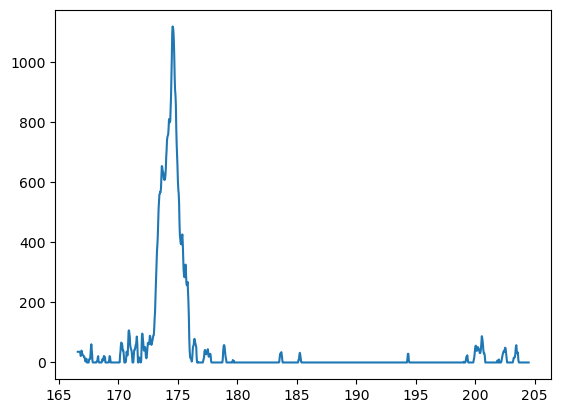

In [61]:
plt.plot(vls_eV, specs[1])

In [66]:
1024/(vls_eV[-1]-vls_eV[0])

27.01959814875185

In [68]:
GDs_bg = np.array(GDs_bg)
xGDs_bg = np.array(xGDs_bg)
ims_bg = np.array(ims_bg)
specs = np.array(specs)
ims_bg.shape

for x,i in enumerate(xGDs_bg):
    if type(xGDs_bg[x]) == type(None):
        xGDs_bg[x] = np.nan 

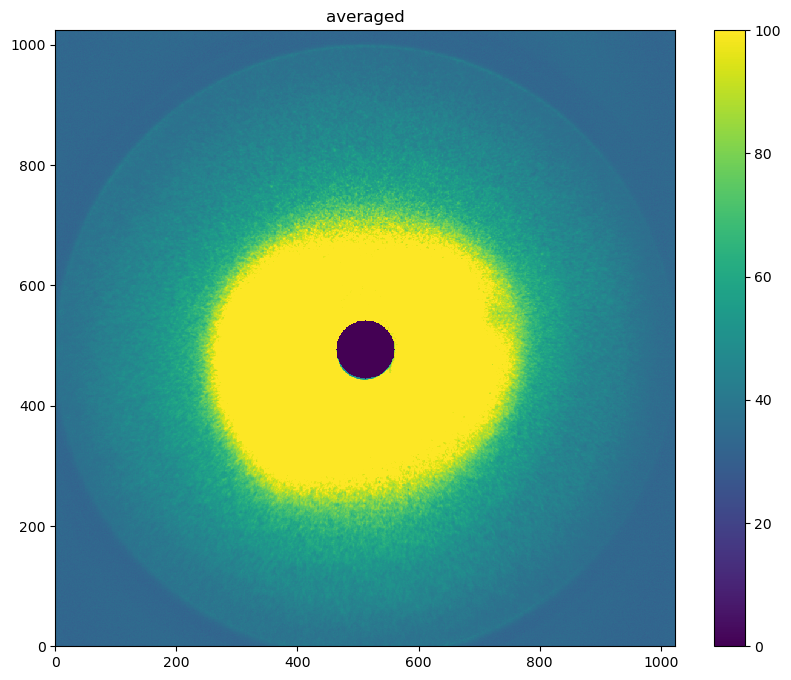

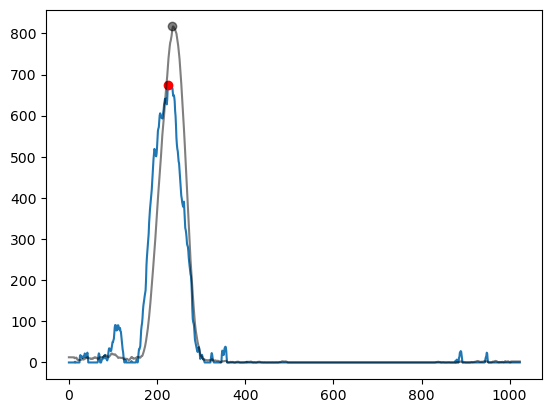

Text(0.5, 1.0, 'roll by 276 in order to center w0 at pixel 512')

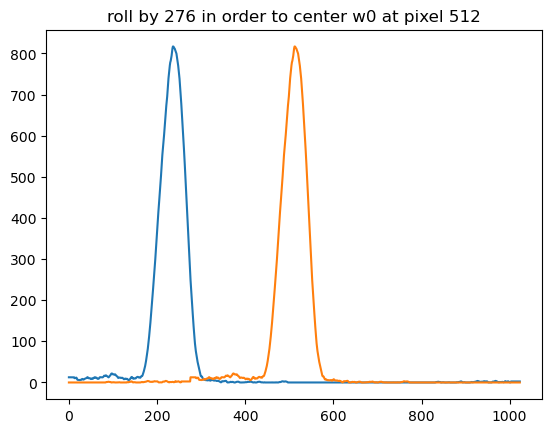

In [78]:
fig,axs = plt.subplots(figsize = (10,8))
ims2plot = np.mean(ims_bg,0)
#ims2plot[ims2plot<30] = 0
plt.pcolormesh((ims2plot), vmax = 100)
plt.colorbar()
plt.title('averaged')
plt.show()

k = 0
plt.plot(specs[k])
plt.plot(get_centroidish(specs[k]), np.max(specs[k]), 'ro')
plt.plot(np.mean(specs,axis = 0), 'k', alpha = 0.5)
plt.plot(get_centroidish(np.mean(specs,axis = 0)), np.max(np.mean(specs,axis = 0)), 'ko', alpha = 0.5)
plt.show()

offset = 512 - np.argmax(np.mean(specs,axis = 0))
plt.plot(np.mean(specs,axis = 0))
plt.plot(np.roll(np.mean(specs,axis = 0), offset))
plt.title('roll by %1.0f in order to center w0 at pixel 512' %offset)

In [80]:
pixpereV = 29.471
resid = np.load('bg_run_286_Mar.npy') #dipole bg

N = 2801
xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
#Interpolate spec outside of the loop to match eV
xeV = pix_2_eV(np.arange(1024), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512)
f = interp1d(np.arange(1024),xeV,bounds_error=False, fill_value = 0)

In [79]:
centroid = []
for s in specs:
    centroid.append(get_centroidish(np.roll(s, offset))) #rolling to center w0 at center of array, pixel 512

In [14]:
cc = np.copy(centroid)

In [15]:
centroid_eV = np.array([f(x) for x in centroid])

In [16]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0][-1] = 0
my_cmap = ListedColormap(my_cmap)

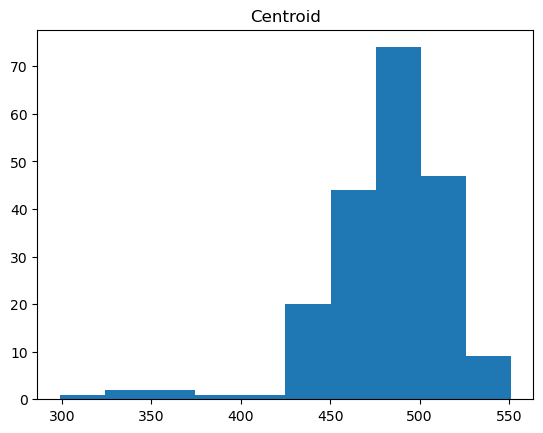

(array([ 1.,  2.,  2.,  1.,  3., 18., 44., 74., 47.,  9.]),
 array([-9.68181818, -8.53636364, -7.39090909, -6.24545455, -5.1       ,
        -3.95454545, -2.80909091, -1.66363636, -0.51818182,  0.62727273,
         1.77272727]),
 <BarContainer object of 10 artists>)

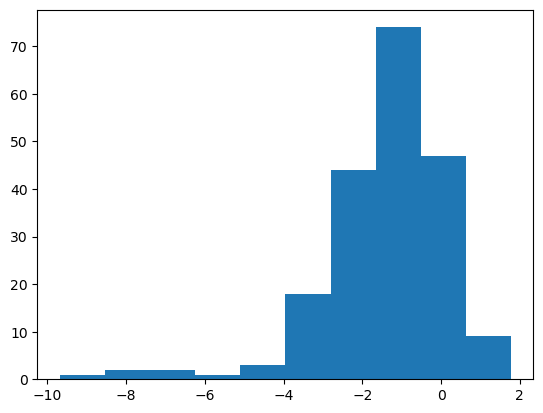

In [17]:
centroid = np.array(centroid)
plt.hist(centroid)
plt.title('Centroid')
plt.show()
plt.hist(centroid_eV)

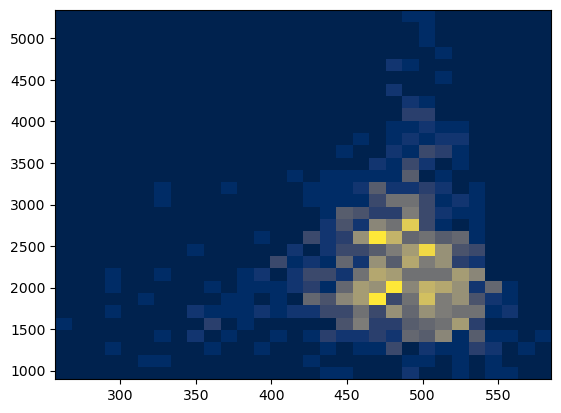

In [52]:
plt.hist2d(centroid, np.sum(specs,axis = 1), bins = 30, cmap ='cividis');

In [17]:
y = np.array(centroid)
corcen = np.zeros((nn,nn))
for i in range(nn): #np.arange(150, 850): #range(1024):
    for j in range(nn): #np.arange(150,850): #in range(1024):
        try:
            x = np.array(ims_bg[:,i,j])       
            corcen[i,j] = np.corrcoef(x,y)[0,1]
        except:
            corcen[i,j] = 0

Text(0.5, 1.0, 'correlated with vls centroid')

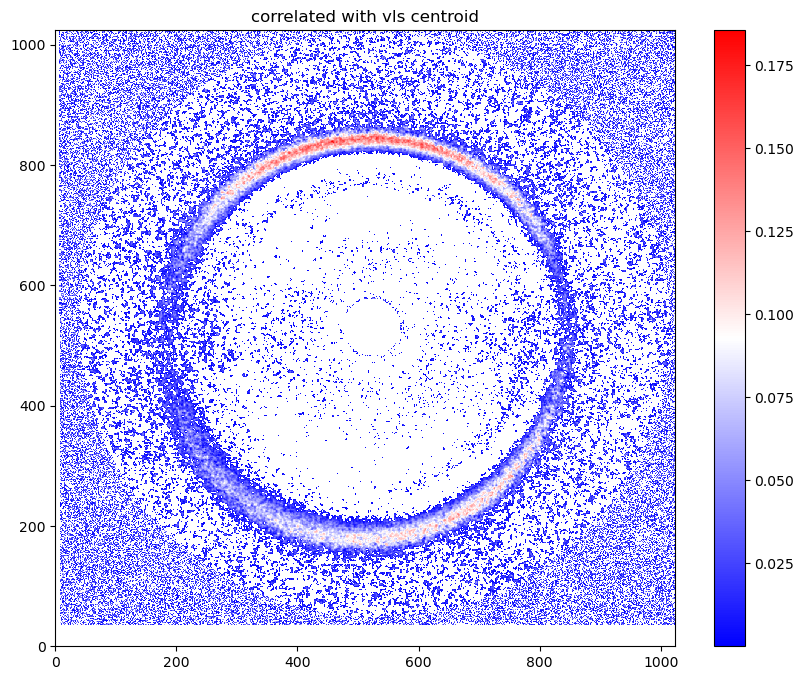

In [20]:
fig,axs = plt.subplots(figsize = (10,8))
toplot = np.copy(corcen)
toplot[toplot<0] = np.nan
plt.pcolormesh(toplot, cmap = 'bwr') #, vmin = 0, vmax = 0.2)
#plt.plot(512,870,'ro')
#plotring()
plt.colorbar()
#plt.title('vls pix = 400')
#plt.title('vls sum')
plt.title('correlated with vls centroid')
#plt.plot(np.arange(515,520),484+np.arange(280,285), 'r.')
#plt.title('centroid')
# plotring(r= 270, col = 'w')
# plotring(r= 310, col = 'w')

(array([1.50000e+02, 4.98200e+03, 1.10222e+05, 4.76529e+05, 2.90904e+05,
        7.62510e+04, 2.48200e+04, 1.07680e+04, 3.40400e+03, 2.17000e+02]),
 array([-0.13138454, -0.09968506, -0.06798558, -0.03628611, -0.00458663,
         0.02711285,  0.05881233,  0.0905118 ,  0.12221128,  0.15391076,
         0.18561024]),
 <BarContainer object of 10 artists>)

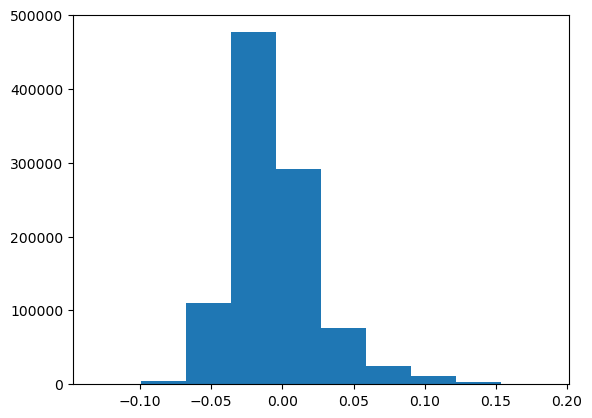

In [21]:
plt.hist(corcen.flatten())

In [18]:
sys.path.append('/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex') # any user should be able
# to load from here
from gData import loadG
from pbasex import pbasex
sys.path.append('/reg/neh/home/tdd14/modules/quadrant/quadrant') # any user should be able
# to load from here
from quadrant import foldQuadrant, resizeFolded
from scipy.ndimage.filters import gaussian_filter1d as gf1d
# Load inversion data
#gData = loadG('/reg/d/psdm/amo/amolu0017/results/taran/calc/pbasex/G_r512_k128_l4.h5', 1) #1 flags load array to make images
gData = loadG('/cds/home/p/paris/vNrecon_NN_May_2021/G_r512_k128_l4.h5', 1)
import cv2

/tmp/ipykernel_318/3186943381.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d as gf1d


In [19]:
# define some parameters
x0,y0=512,512 #center of the VMI detector
#vmi_im = bg #np.ones((1024, 1024)) # this can be a 2D array with dimensions (n_pix x n_pix) or a 3D array with dimensions
# (n_pix x n_pix x n_ims)
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]] # define quadrants
# to use, clockwise from bottom right when full im is plotted with pcolormesh (although
# this plotting behavior should probably be expected to change and should be checked)
ke_calib = lambda x: 2e-4 * x**2 # kinetic energy calibration (if you want to plot with one below)
ke_calib = lambda x: x # you could just have this if you don't have a KE yet

In [20]:
# tt = (np.abs(np.array(centroid_eV) - 2)<= 0.3) #& (np.abs(np.array(dts_bg)-dts[look]) < timedelta(minutes=2))]
    
# bg_sort = np.mean(ims_bg[tt],axis = 0)
# nn_sort = len(ims_bg[tt])
# ii = np.rot90(bg_sort)
vmi_im = mf(np.rot90(ims_bg[0]),20) #mf(ii,10) #np.rot90(ims_bg[0])
vmi_im = gf(vmi_im,10)

In [213]:
np.sum(ims_bg[0])

62170826.962890625

In [214]:
np.sum(ii)

32075626.591796875

In [282]:
vmi_im = np.rot90(gf(mf(quads2*np.mean(imsM,axis = 0),20),10))

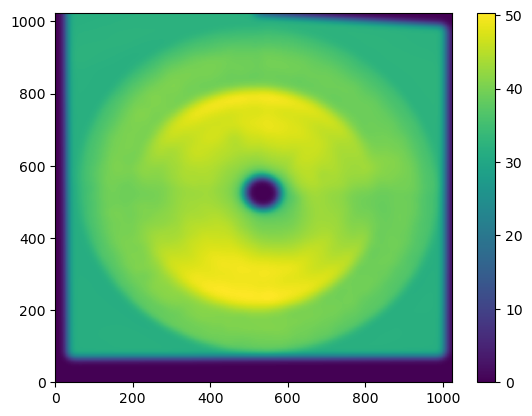

In [285]:
plt.pcolormesh(np.rot90(vmi_im, -1))
plt.colorbar()

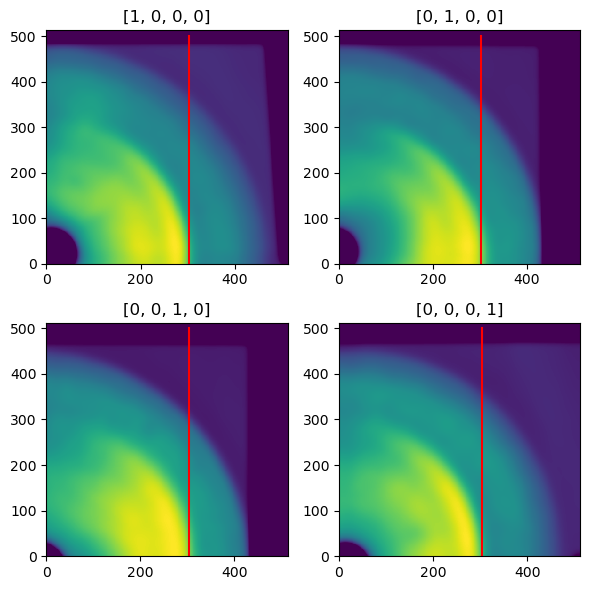

In [283]:
plt.figure(figsize=(6,6))
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]] 
for i1, quadrant_filter_tmp in enumerate(quadrant_filters):
    plt.subplot(2,2,i1+1)
    plt.pcolormesh(foldQuadrant((vmi_im if len(vmi_im.shape)==2 else vmi_im[:,:,0]), x0, y0, quadrant_filter_tmp),vmin = 30)
    plt.title(str(quadrant_filter_tmp))
    plt.plot([303,303],[0,500], 'r-')
    # plt.xlim(0,512), plt.ylim(0,512)
plt.tight_layout()
plt.show()

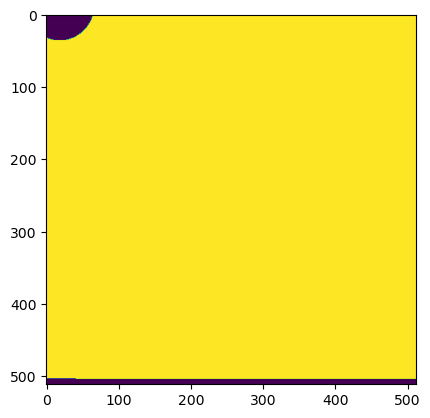

In [141]:
w = vmi_im[512:,512:] 
w[w!=0] = 1
w[w==0] = 0.01
plt.imshow(w)

folded images
finished inverting


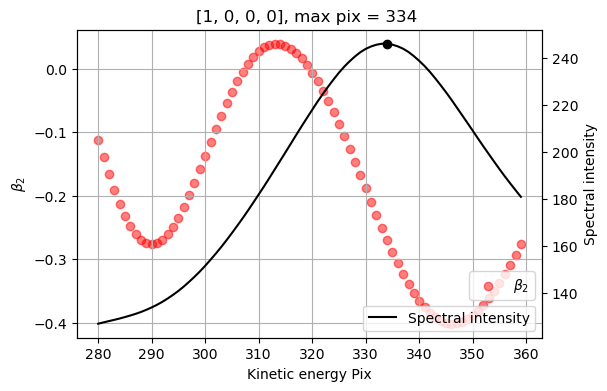

folded images
finished inverting


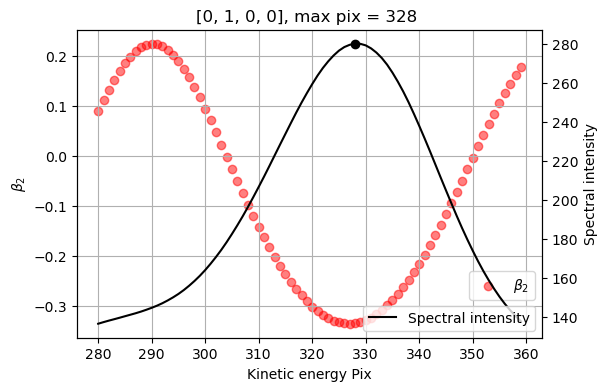

folded images
finished inverting


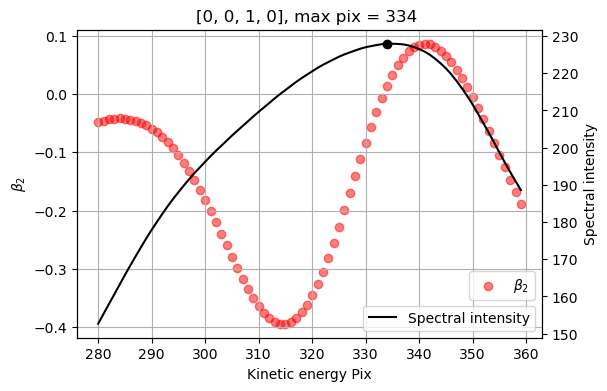

folded images
finished inverting


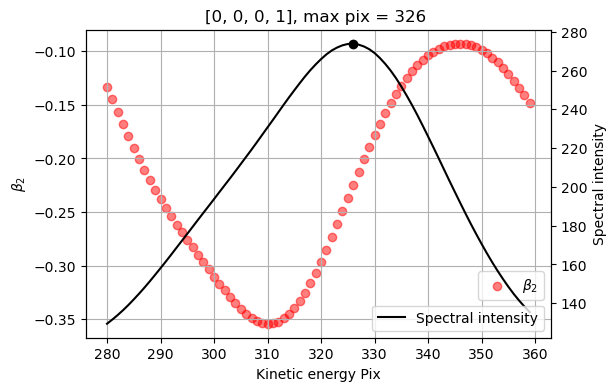

In [228]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]]
for quadrant_filter in quadrant_filters:
#quadrant_filter = [1,1,1,0] #[1,1,1,1] # this is the quadrant filter you want to use
# for the inversion

    folded = resizeFolded(foldQuadrant(vmi_im, x0, y0, quadrant_filter), 512)
    print('folded images')
    # Apply the pBASEX inversion
    out = pbasex(folded, gData, make_images=True, weights = w) # the alpha is redundant here #weights
    print('finished inverting')

    ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
    betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
    
    spec_to_plot = ints[0] if len(ints.shape)==2 else ints
    betas_to_plot = betas[0] if len(betas.shape)==2 else betas
    r1 = 280
    r2 = 360

    plt.figure(figsize=(6,4))

    plt.scatter(ke_calib(np.arange(r1,r2)), betas_to_plot[r1:r2], \
                alpha=0.5, marker='o', c='r', label = r'$\beta_2$')
    plt.ylabel(r'$\beta_2$')
    plt.grid()
    plt.xlabel('Kinetic energy Pix') # you may only be plotting in pix. if don't have a KE calibration yet!
    plt.legend(loc = 4, bbox_to_anchor=(1, 0.1))
    plt.twinx()

    plt.plot(ke_calib(np.arange(r1,r2)), spec_to_plot[r1:r2], c='k', label = 'Spectral intensity')
    plt.ylabel('Spectral intensity')
    plt.plot(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])],np.max(spec_to_plot[r1:r2]), 'ko')
    plt.title(str(quadrant_filter) + ', max pix = %1.0f ' %(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])]))
    plt.legend(loc = 4)
    plt.show()

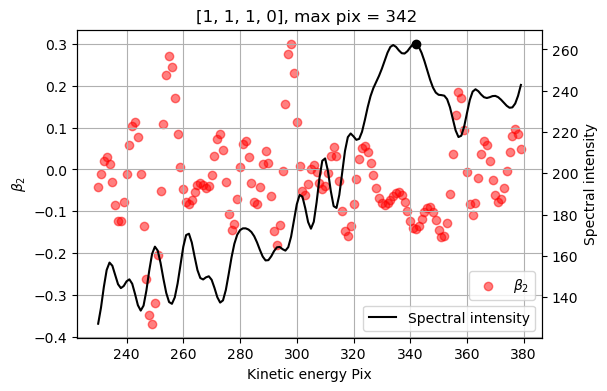

In [104]:
spec_to_plot = ints[0] if len(ints.shape)==2 else ints
betas_to_plot = betas[0] if len(betas.shape)==2 else betas
r1 = 230
r2 = 355

plt.figure(figsize=(6,4))

plt.scatter(ke_calib(np.arange(r1,r2)), betas_to_plot[r1:r2], \
            alpha=0.5, marker='o', c='r', label = r'$\beta_2$')
plt.ylabel(r'$\beta_2$')
plt.grid()
plt.xlabel('Kinetic energy Pix') # you may only be plotting in pix. if don't have a KE calibration yet!
plt.legend(loc = 4, bbox_to_anchor=(1, 0.1))
plt.twinx()

plt.plot(ke_calib(np.arange(r1,r2)), spec_to_plot[r1:r2], c='k', label = 'Spectral intensity')
plt.ylabel('Spectral intensity')
plt.plot(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])],np.max(spec_to_plot[r1:r2]), 'ko')
plt.title(str(quadrant_filter) + ', max pix = %1.0f ' %(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])]))
plt.legend(loc = 4)
plt.show()

(array([  3.,   0.,   1.,   2.,   4.,   0.,   6.,   5.,   4.,   3.,   4.,
          3.,   2.,   7.,  15.,   9.,  33.,  44.,  71., 110., 112., 144.,
        140., 108.,  76.,  49.,  29.,  13.,   2.,   2.]),
 array([-10.        ,  -9.58484848,  -9.16969697,  -8.75454545,
         -8.33939394,  -7.92424242,  -7.50909091,  -7.09393939,
         -6.67878788,  -6.26363636,  -5.84848485,  -5.43333333,
         -5.01818182,  -4.6030303 ,  -4.18787879,  -3.77272727,
         -3.35757576,  -2.94242424,  -2.52727273,  -2.11212121,
         -1.6969697 ,  -1.28181818,  -0.86666667,  -0.45151515,
         -0.03636364,   0.37878788,   0.79393939,   1.20909091,
          1.62424242,   2.03939394,   2.45454545]),
 <BarContainer object of 30 artists>)

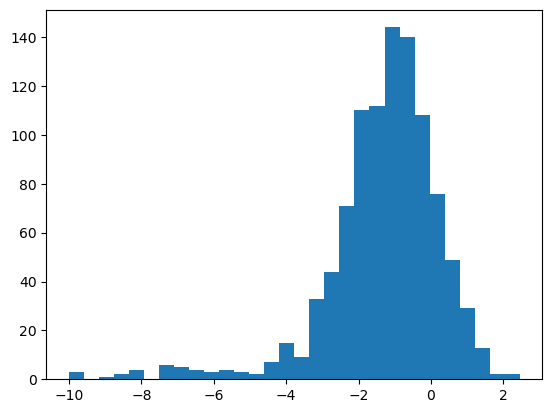

In [161]:
plt.hist(centroid_eV, bins = 30)

In [162]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,0], [1,0,0,1]]
look_eVs = np.linspace(-6,3,30) #[-4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5,2.0,3.3]
print(look_eVs)
n = len(look_eVs)
rrs = [] #np.zeros((n,len(quadrant_filters)))
nns = []
r1= 260 
r2 = 355
ims_bg = np.array(ims_bg)
for i in range(n):
    centroid_look_eV = look_eVs[i]
    tt = (np.abs(np.array(centroid_eV) - centroid_look_eV)<= 0.02 )& (GDs_bg > 0.15)
    
    bg_sort = np.mean(ims_bg[tt],axis = 0)
    nn_sort = len(ims_bg[tt])
    if nn_sort<5: continue
    ii = np.rot90(bg_sort)
    temp = []
    for j, qfilter in enumerate(quadrant_filters):
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
    
        #centroid = get_centroidish(spec_to_plot[r1:r2])
        #rrs[i,j] = ke_calib(np.arange(r1,r2))[centroid]
        temp.append(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])])
    rrs.append(temp)
    nns.append(centroid_look_eV)
    print(nn_sort, temp)


[-6.         -5.68965517 -5.37931034 -5.06896552 -4.75862069 -4.44827586
 -4.13793103 -3.82758621 -3.51724138 -3.20689655 -2.89655172 -2.5862069
 -2.27586207 -1.96551724 -1.65517241 -1.34482759 -1.03448276 -0.72413793
 -0.4137931  -0.10344828  0.20689655  0.51724138  0.82758621  1.13793103
  1.44827586  1.75862069  2.06896552  2.37931034  2.68965517  3.        ]
7 [329, 313, 333, 317, 330, 317]
12 [326, 314, 320, 313, 320, 322]
11 [332, 314, 325, 328, 325, 320]
13 [333, 329, 333, 322, 332, 323]
15 [328, 318, 323, 318, 328, 328]
17 [335, 324, 329, 314, 327, 335]
18 [334, 334, 334, 322, 334, 322]
10 [334, 330, 337, 330, 336, 333]


In [163]:
rrs=np.array(rrs)

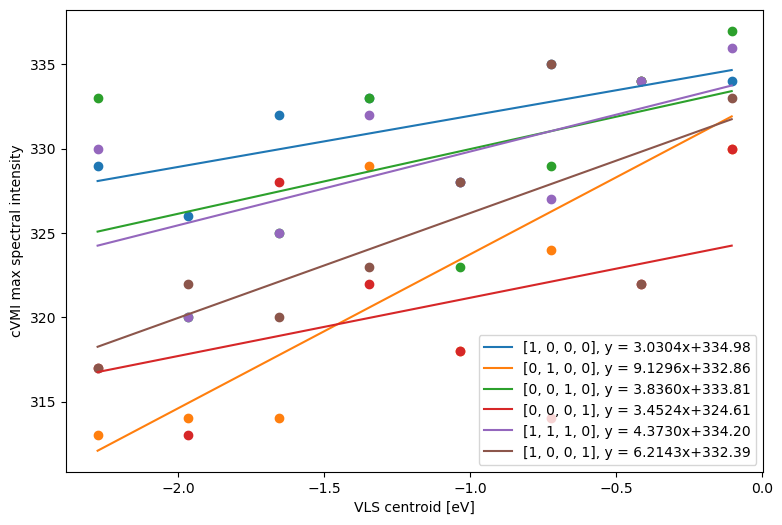

In [164]:
#alphas = [np.min((nn/30,1)) for nn in nns]
fig,axs = plt.subplots(figsize = (9,6))
#look_eVs = np.hstack((410, look_eVs))
#rrs = np.vstack((np.zeros(4),rrs))
#nns = np.hstack((0.1,nns))
for j, qfilter in enumerate(quadrant_filters):
    rplot = rrs[:,j]
    #ind = np.argsort(rplot)
    #rplot = rplot[ind]
    eVplot = nns #look_eVs #[ind]
    
    plt.scatter(eVplot, rplot) #, alpha = alphas)
    #plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
    #m,b,c = np.polyfit(eVplot, rplot, 2)
    m,b = np.polyfit(eVplot, rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    #plt.plot(eV,m*eV**2+b*eV+c, label = str(qfilter) + ', y = %1.4fx^2+%1.2fx+%1.2f' %(m,b,c))
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))

plt.xlabel('VLS centroid [eV]')
plt.ylabel('cVMI max spectral intensity')
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

In [165]:
len(ims_bg)

1001

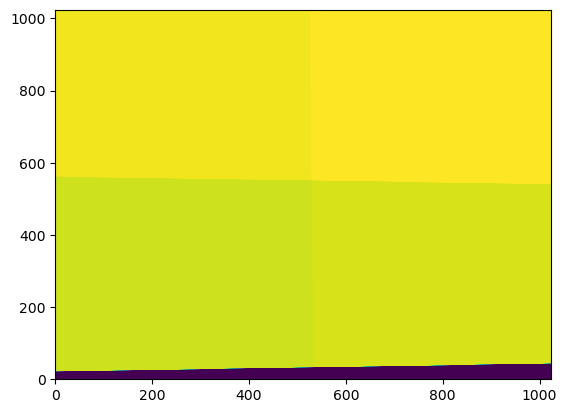

In [21]:
xshift, yshift =  7+2, 33+2
rshift = -2 #-2 #20


# Coordinates that you want to Perspective Transform
pts1 = np.float32([[0,0],\
                   [0,1024],\
                   [1024,0],\
                   [1024, 1024]])


# Size of the Transformed Image
pts2 = np.float32([[0+xshift+rshift-37,0 + yshift+rshift-12],\
                   [0+xshift+rshift-24,1024 + yshift-rshift+22],\
                   [1024+xshift-rshift+15,0 + yshift+rshift+11],\
                   [1024+xshift-rshift-10,1024 + yshift-rshift-41.5]])
#make quads for 1024x1024
quads=np.ones((1024,1024))
quads[:512,:512]=0.925
quads[:512,512:]=0.9375
quads[512:,:512]=0.98
quads[512:,512:]=1
MM = cv2.getPerspectiveTransform(pts1,pts2)
quads = cv2.warpPerspective(quads,MM,(1024,1024))
plt.pcolormesh(quads)


quads2=np.ones((1024,1024))
quads2[:512,:512]=.97275
quads2[:512,512:]=.97775
quads2[512:,:512]=0.988
quads2[512:,512:]=1
quads2 = cv2.warpPerspective(quads2,MM,(1024,1024))


In [24]:
resid = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Jan/bg_run_112_2.npy')
MM = make_MM([ -9.54346309,  -2.83400071,   7.03704724,  -4.72205756,   3.24594164, 2.42572902, -10.96778242,  -8.0874046 ])
quads = cv2.warpPerspective(make_quads([0.9349,0.9431,0.9565,0.9739]),MM,(1024,1024)) #cv2.warpPerspective(make_quads([0.9026,0.90,0.9155,0.998]),MM,(1024,1024))


In [25]:
imsM = [cv2.warpPerspective(ii,MM,(1024,1024)) for ii in ims_bg]

In [146]:
Qtest = [-1.07585089e-02, -4.25586011e-03,  8.45381338e-03,  9.03551877e-02,
        1.76173806e-01, -6.77977502e-03,  2.98451427e-02,  4.63283621e-02,
        3.66842821e-02, -6.66905940e-02, -2.09418654e-01, -8.36370438e-02,
       -4.81476299e-02, -1.21407732e-01, -1.79769471e-01,  4.15808409e-02,
        2.18515456e-01,  1.91996805e-02,  7.26806298e-02,  2.07818970e-01,
        5.12195110e-01, -4.54948097e-01, -7.07501248e-02, -4.92336079e-02,
       -5.62960207e-02, -1.62357137e-01, -7.80972183e-01,  8.14761281e-01,
       -8.49807337e-02, -5.29452600e-03,  2.54378584e-03, -3.54891159e-02,
       -5.50798178e-01, -1.47484645e-01,  1.02233291e-01,  2.09665745e-02,
       -5.07804863e-02, -1.23746768e-01, -9.87925082e-02, -8.33486468e-02,
       -1.42431289e-01,  3.19156758e-02,  9.73413289e-02,  1.90352216e-01,
        2.32669085e-01,  2.73226708e-01,  7.88746238e-01, -4.30645645e-02,
       -1.12325422e-01, -2.58713931e-01, -4.41082031e-01, -3.19419771e-01,
       -1.82732239e-01, -3.90820860e-05,  1.28548564e-02,  1.61773235e-01,
        5.37355363e-01, -1.83251858e-01,  5.44768907e-02,  5.10844477e-02,
        1.79196671e-01,  5.06996632e-01,  7.66795635e-01,  2.05154903e-02,
       -1.13471579e-02, -5.31162880e-02, -1.64196029e-01, -5.60077019e-02,
        2.64100760e-01,  3.30865048e-02,  1.54454475e-02]

check = np.mean(np.array(imsM)[np.where(np.abs(np.array(centroid_eV)-1) <= 0.25)[0]],axis = 0)
tocheck = gf(mf(quads2*check,20),10)
bg_plot = rebin(rebin(tocheck,4),4)

In [147]:
resid_scale = resid/np.mean(resid*rebin(rebin(maskscale,4),4))*np.mean(tocheck*maskscale)

In [148]:
maskscale2 = np.zeros((1024,1024)) ###before stretching
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale2 [(rs>120)]=1
maskscale2 [(rs>420)]=0
maskscale2 = rebin(rebin(maskscale2,4),4)

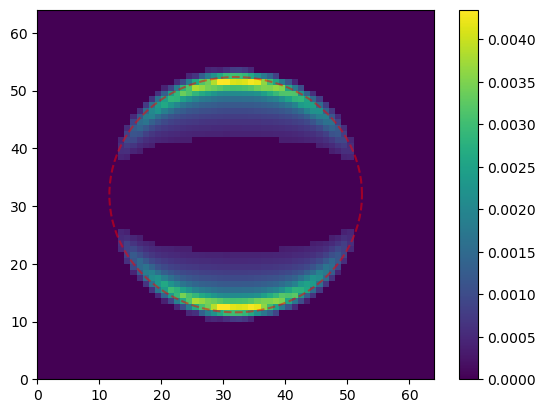

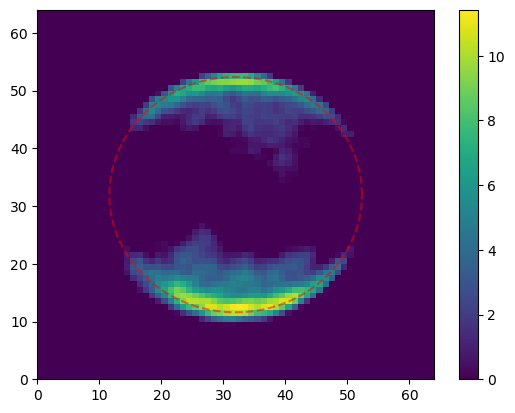

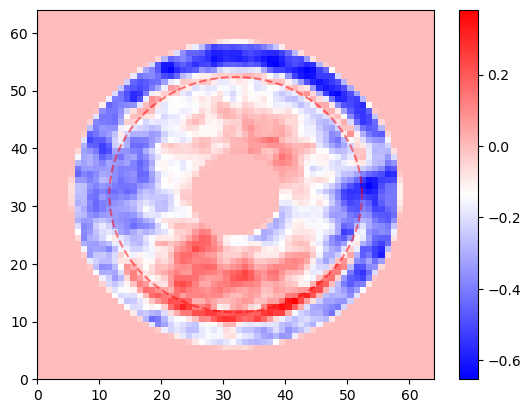

In [149]:
Q = Qtest
N_basis = 36
phis = np.linspace(0,360,100)*np.pi/180
Q1=Q[0:N_basis]
Q1=np.reshape(Q1,[1,N_basis])
Q2=np.concatenate(([0],Q[N_basis:2*N_basis-1]))
Q2=np.reshape(Q2,[1,N_basis])
Qguess=Q1+1j*Q2
Qguess = [[-5.63275893e-01+6.48772729e+00j],
       [ 4.62272019e+00+1.44083312e+00j],
       [ 8.73231438e+00+2.50649116e+00j],
       [ 9.62667100e+00+6.49240703e+00j],
       [ 6.48445373e+00+9.02592191e+00j],
       [-8.61945967e+00+6.80863342e+00j],
       [-7.14156748e+00-1.35984845e+01j],
       [-1.14486791e+01-3.14939793e+00j],
       [-2.20070077e+01-7.21849181e-01j],
       [-2.41261420e+01-1.38720942e+01j],
       [-2.06442542e+01-1.45035221e+01j],
       [-2.41435671e+00-7.48088255e+00j],
       [ 1.72207982e+01+1.09461862e+01j],
       [ 3.58940161e+00+1.47198072e+01j],
       [ 4.51941903e+01-4.12481461e+01j],
       [ 5.15864393e+01+5.24320609e+01j],
       [ 8.55723992e+00+1.80737487e+01j],
       [-8.94516676e+00+9.04400284e+00j],
       [-3.51951934e+01+1.07065599e+01j],
       [-7.42507330e+01-1.55296154e+02j],
       [ 4.04919110e+02+8.87993319e+02j],
       [ 4.02239767e+02-8.10771822e+02j],
       [-2.20964106e+01+2.94119374e+01j],
       [ 2.81331945e-01-1.07559510e+01j],
       [ 5.73951994e+00-4.30167956e+01j],
       [-1.74839857e+01-8.30363573e+01j],
       [-1.46913320e+02-1.09840810e+02j],
       [-1.53115184e+02+7.73778031e+01j],
       [-4.00440446e+01+6.03002209e+01j],
       [-3.02931231e+01+2.10914279e+01j],
       [ 1.16916391e+01+2.05316820e+01j],
       [ 2.48669907e+01+3.40682820e+01j],
       [ 5.48542107e+01+2.56842564e+01j],
       [ 5.89056036e+01-1.21357851e+01j],
       [ 3.92687171e+01-1.98752493e+01j],
       [ 1.24506419e+01-1.08569542e+00j]]
Qguess=np.reshape(Qguess,[N_basis,1])
Mgr=np.real(np.matmul(np.matmul(Qguess,Qguess.conj().transpose()).transpose().flatten(),Bp_basis))
Mgr=Mgr/np.sum(Mgr)
Mgr[Mgr<0.00032] = 0
Mgr=Mgr/np.sum(Mgr)
Mgr = np.reshape(Mgr, [64,64])
plt.pcolormesh(Mgr)
plt.colorbar()
plt.plot((511.5+ 326*np.cos(phis))/16, (511.5+ 326*np.sin(phis))/16, 'r--', alpha = 0.5)
plt.show()


#plt.figure(figsize = (14,12))
plt.pcolormesh(maskscale2*(bg_plot-resid_scale), vmin = 0) #, vmin = 39) #, vmin = 40, vmax = 45)
plt.colorbar()
plt.plot((511.5+ 326*np.cos(phis))/16, (511.5+ 326*np.sin(phis))/16, 'r--', alpha = 0.5)
plt.show()

Me = maskscale2*(bg_plot-resid_scale)/np.max(maskscale2*(bg_plot-resid_scale))
Ms = Mgr/np.max(Mgr)
plt.pcolormesh(Me-Ms, cmap = 'bwr') #, vmin = 39) #, vmin = 40, vmax = 45)
plt.colorbar()
plt.plot((511.5+ 326*np.cos(phis))/16, (511.5+ 326*np.sin(phis))/16, 'r--', alpha = 0.5)
plt.show()


In [150]:
!pwd

/cds/home/p/paris/reconVMI_clean/recon X510 Nov


In [153]:
np.save( '/cds/home/p/paris/reconVMI_clean/recon X510 Jan/unstreaked_M0_112.npy',cv2.resize((Mgr), (1024,1024), interpolation = cv2.INTER_AREA))

In [145]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]] #, [1,1,1,0], [1,0,0,1]]
x0,y0 = 512,512
ii = cv2.resize(np.rot90(Mgr), (1024,1024), interpolation = cv2.INTER_AREA)
    
for j, qfilter in enumerate(quadrant_filters):

    folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
    out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

    ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
    betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
    spec_to_plot = ints[0] if len(ints.shape)==2 else ints

    centroid = get_centroidish(spec_to_plot[r1:r2])
    print(qfilter, ke_calib(np.arange(r1,r2))[centroid])



[1, 0, 0, 0] 323
[0, 1, 0, 0] 324
[0, 0, 1, 0] 323
[0, 0, 0, 1] 323
[1, 1, 1, 1] 323


In [119]:
bg_check = maskscale2*(bg_plot-resid_scale)
bg_check[bg_check<0] = 0
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]] #, [1,1,1,0], [1,0,0,1]]
x0,y0 = 512,512
ii = cv2.resize(np.rot90(bg_check), (1024,1024), interpolation = cv2.INTER_AREA)
    
for j, qfilter in enumerate(quadrant_filters):

    folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
    out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

    ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
    betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
    spec_to_plot = ints[0] if len(ints.shape)==2 else ints

    centroid = get_centroidish(spec_to_plot[r1:r2])
    print(qfilter, ke_calib(np.arange(r1,r2))[centroid])



[1, 0, 0, 0] 311
[0, 1, 0, 0] 312
[0, 0, 1, 0] 311
[0, 0, 0, 1] 308
[1, 1, 1, 1] 310


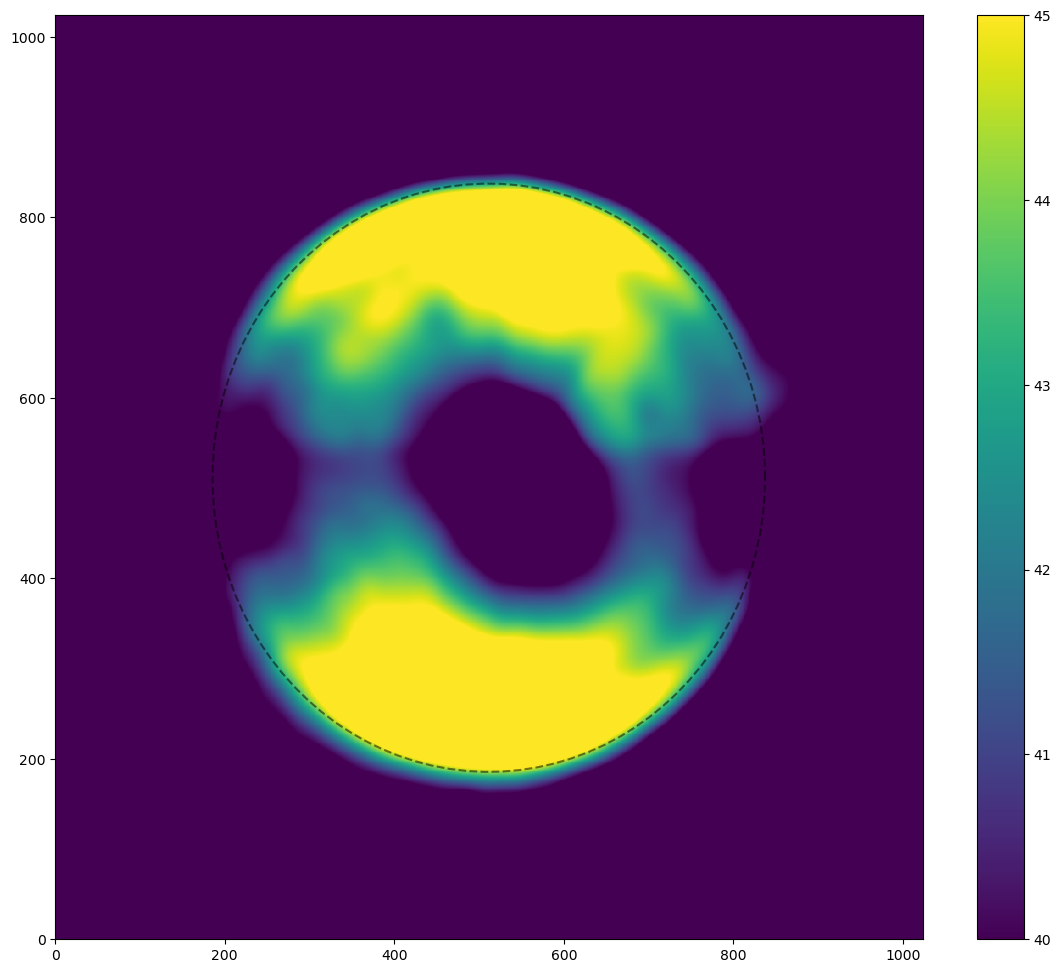

In [26]:
plt.figure(figsize = (14,12))
plt.pcolormesh(gf(mf(np.mean(imsM[:100],axis = 0)*quads,20),10), vmin = 40, vmax = 45)
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(511.5+ 326*np.cos(phis), 511.5+ 326*np.sin(phis), 'k--', alpha = 0.5)
plt.colorbar()

In [22]:
check = np.mean(np.array(imsM)[np.where(np.abs(np.array(centroid)-497) <= 1)[0]],axis = 0)
tocheck = gf(mf(quads2*check,20),10)

NameError: name 'imsM' is not defined

In [23]:
check = np.array(imsM[800])
tocheck = gf(mf(quads*check,20),10)

In [24]:
tocheck.shape

(1024, 1024)

In [25]:
resid = np.load('/cds/home/p/paris/reconVMI_clean/resid_bg_mfgf10_unsat5.npy')
resid = cv2.resize(resid, (1024,1024), interpolation = cv2.INTER_AREA)

In [26]:
resid_scale = resid/np.mean(resid*maskscale)*np.mean(tocheck*maskscale)
    
imstocheck = tocheck - resid_scale
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>100) & (rs<420)]=1

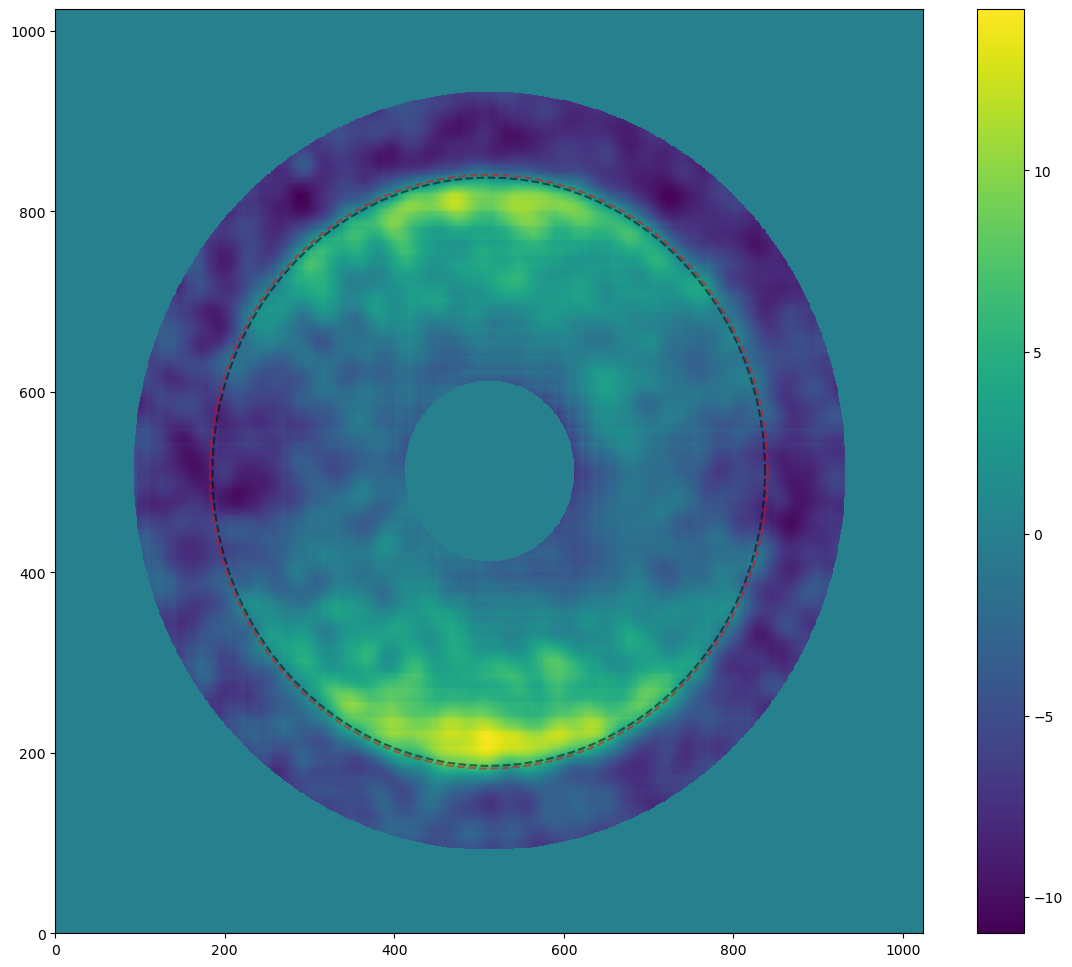

In [30]:
plt.figure(figsize = (14,12))
plt.pcolormesh(imstocheck*maskhm) #, vmin = 30, vmax = 42)
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(511.5+ 326*np.cos(phis), 511.5+ 326*np.sin(phis), 'k--', alpha = 0.5)
plt.plot(511.5+ 329*np.cos(phis), 511.5+ 329*np.sin(phis), 'r--', alpha = 0.5)
plt.colorbar()

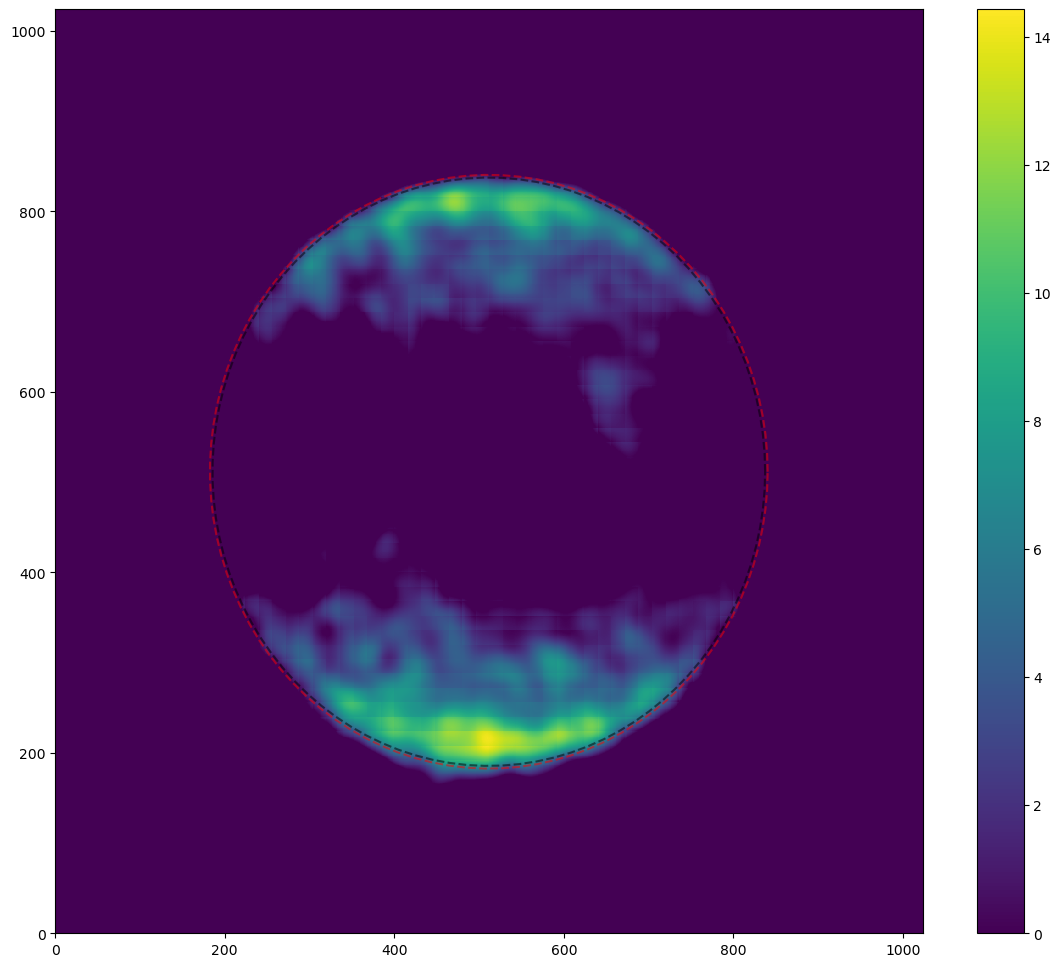

In [31]:
imstocheck[imstocheck <0 ] = 0
plt.figure(figsize = (14,12))
plt.pcolormesh(imstocheck*maskhm) #, vmin = 30, vmax = 42)
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(511.5+ 326*np.cos(phis), 511.5+ 326*np.sin(phis), 'k--', alpha = 0.5)
plt.plot(511.5+ 329*np.cos(phis), 511.5+ 329*np.sin(phis), 'r--', alpha = 0.5)
plt.colorbar()

In [190]:
ims_bg470 = np.array(imsM)[np.where(np.abs(np.array(centroid)-497) <= 1)[0]]
len(ims_bg470)

0

In [212]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]] #, [1,1,1,0], [1,0,0,1]]

n = 1 #len(ims_bg470)
rrs = [] #np.zeros((n,len(quadrant_filters)))
nns = []
r1= 300 
r2 = 400
for i in range(n):
    #ii = np.rot90(np.mean(ims_bg470,axis = 0)*quads2)
    #ii = np.rot90(ims_bg470[i])
    ii = np.rot90(imstocheck)
    #if np.sum(ii) < 3.5e7: continue
    #ii = gf(mf(ii,20),10)
    temp = []
    for j, qfilter in enumerate(quadrant_filters):
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
    
        #centroid = get_centroidish(spec_to_plot[r1:r2])
        #rrs[i,j] = ke_calib(np.arange(r1,r2))[centroid]
        temp.append(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])])
    
    rrs.append(temp)
    nns.append(centroid_eV[i])
    print(len(nns), temp)


1 [373, 361, 357, 362, 368]


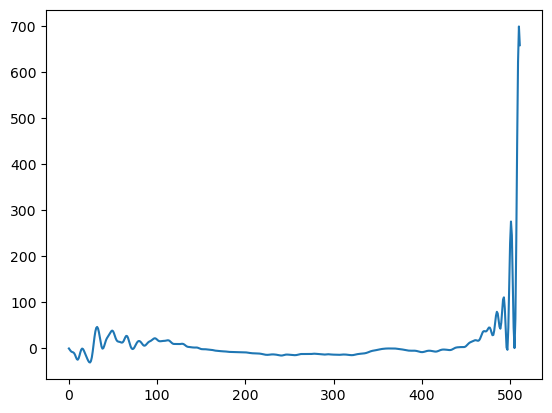

In [213]:
plt.plot(spec_to_plot)

In [115]:
np.mean(rrs, axis = 0)

array([335.36363636, 335.45454545, 335.45454545, 335.        ,
       335.54545455])

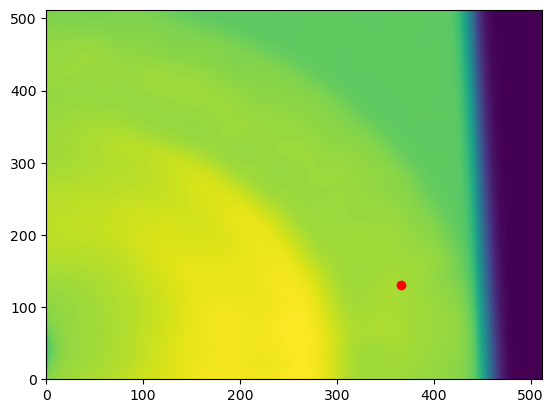

In [87]:
folded = resizeFolded(foldQuadrant(ii, x0, y0, [0,1,0,0]), 512)
out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
spec_to_plot = ints[0] if len(ints.shape)==2 else ints
plt.pcolormesh(folded)
plt.plot(a,130, 'ro')

399

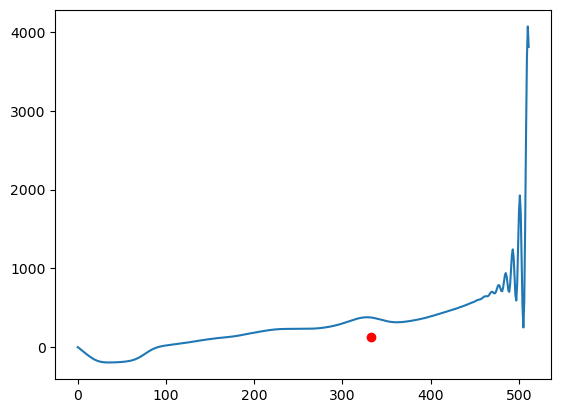

In [99]:
plt.plot(spec_to_plot)
a = (ke_calib(np.arange(200,400))[np.argmax(spec_to_plot[200:400])])
plt.plot(332,130, 'ro')
a

488


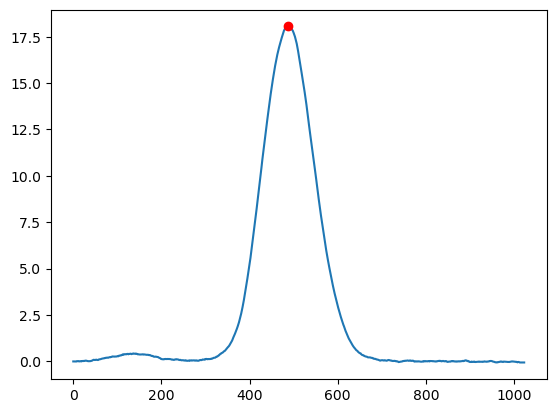

In [46]:
plt.plot(np.mean(specs,axis = 0))
plt.plot(get_centroidish(np.mean(specs,axis = 0)), np.max(np.mean(specs,axis = 0)), 'ro')
print(get_centroidish(np.mean(specs,axis = 0)))

In [102]:
#centroid 470
Q = np.array([[ 0.03707759+0.j        ],
       [ 0.08203505+0.11701591j],
       [-0.90492237-0.64258611j],
       [-0.7348488 +0.11722899j],
       [-0.34869632+0.328987j  ],
       [-0.22415948+0.05243224j],
       [-0.1477793 +0.0150217j ],
       [-0.19492874-0.1489372j ],
       [ 0.57834554-0.30397394j],
       [ 0.34745026-0.00481135j],
       [ 0.51322579-0.07231107j],
       [ 0.37114888+0.01035086j],
       [ 0.15581702-0.15608743j],
       [ 0.88961846-0.00595623j],
       [-0.52094936+0.84299016j],
       [-0.25523382+0.10702207j],
       [-0.81323135-0.14806595j],
       [-0.34189668-0.10188241j],
       [-0.01899661+0.03700193j],
       [ 0.08255794+0.15559797j],
       [-0.68559331+0.42118999j],
       [ 1.08720124-0.20505619j],
       [ 0.08332486+0.4336223j ],
       [ 0.31919125+0.15543756j],
       [ 0.02242486+0.0415572j ],
       [-0.01589709+0.11844697j],
       [ 0.02574129+0.42892036j],
       [-0.97821063+0.28628924j],
       [ 1.50949812+1.21994221j],
       [-0.79793817-0.88265115j],
       [-0.03021959-0.07211957j],
       [-0.22272743-0.20419972j],
       [-0.38973758-1.87574291j],
       [ 3.43795013-0.17121179j],
       [ 0.39475396+0.21401574j],
       [ 0.13528456+0.14789328j]])

328
329
328
328
328


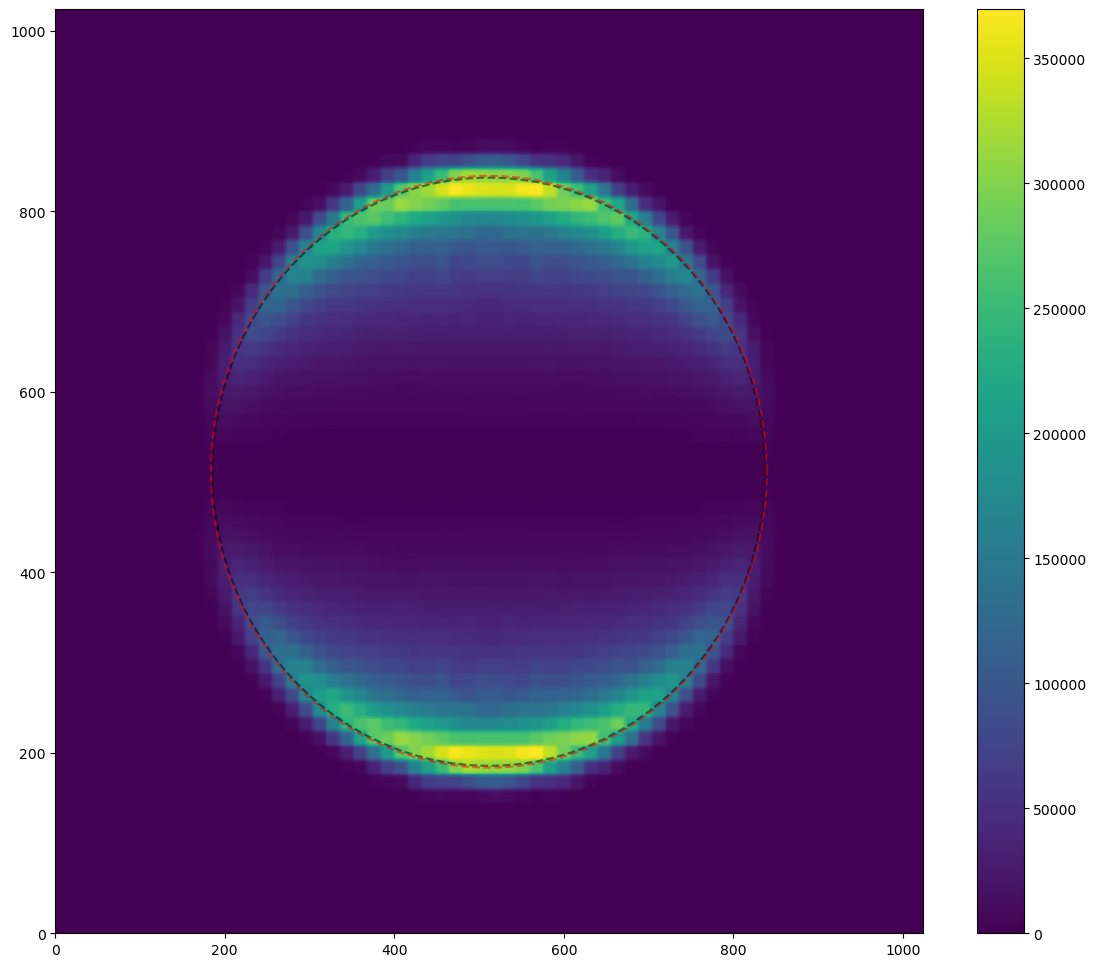

In [182]:
plt.figure(figsize = (14,12))
Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


#Msol1 =  make_bg_fixed(sss, ee, vNaxis0, alpha0, Bp_basis0, vls_pitch = 5.399977, order = 3)
Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
ii = gf(cv2.resize(Msol1, (1024,1024), interpolation = cv2.INTER_AREA),2)
plt.pcolormesh(ii)
plt.colorbar()
plt.plot(511.5+ 326*np.cos(phis), 511.5+ 326*np.sin(phis), 'k--', alpha = 0.5)
plt.plot(511.5+ 328*np.cos(phis), 511.5+ 328*np.sin(phis), 'r--', alpha = 0.5)


for j, qfilter in enumerate(quadrant_filters):

    folded = resizeFolded(foldQuadrant(np.rot90(ii), x0, y0, qfilter), 512)
    out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

    ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
    betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
    spec_to_plot = ints[0] if len(ints.shape)==2 else ints

    centroid = get_centroidish(spec_to_plot[r1:r2])

    print(ke_calib(np.arange(r1,r2))[centroid])

In [20]:
mdat= np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Ms_Dec16.npy', allow_pickle = True)[()]
specdat = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/specs_Dec16.npy', allow_pickle = True)[()]

In [ ]:
rshift = -20 #-2 #20


# Coordinates that you want to Perspective Transform
pts1 = np.float32([[0,0],\
                   [0,64],\
                   [64,0],\
                   [64, 64]])


# Size of the Transformed Image
pts2 = np.float32([[0+rshift,0 +rshift],\
                   [0+rshift,64 -rshift],\
                   [64-rshift,0 +rshift],\
                   [64-rshift,64 -rshift]])
#make quads for 1024x1024
quads=np.ones((1024,1024))
quads[:512,:512]=0.925
quads[:512,512:]=0.9375
quads[512:,:512]=0.98
quads[512:,512:]=1
MM = cv2.getPerspectiveTransform(pts1,pts2)
mm = cv2.warpPerspective(mdat[21],MM,(64,64))
fig,axs =plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
axs[0].pcolormesh(mdat[21])
axs[1].pcolormesh(mm)

axs[0].plot(32+ 320/16*np.cos(phis), 32+ 320/16*np.sin(phis), 'k--', alpha = 0.5)
axs[0].plot(32+ 328/16*np.cos(phis), 32+ 328/16*np.sin(phis), 'k--', alpha = 0.5)

axs[1].plot(32+ 320/16*np.cos(phis), 32+ 320/16*np.sin(phis), 'k--', alpha = 0.5)
axs[1].plot(32+ 328/16*np.cos(phis), 32+ 328/16*np.sin(phis), 'k--', alpha = 0.5)



In [18]:
quads3=np.ones((1024,1024))
quads3[:512,:512]= 0.9532994691535456
quads3[:512,512:]= 0.9614720211357738
quads3[512:,:512]= 0.968461293916009
quads3[512:,512:]= 0.9826031904867956


In [27]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]] #, [1,1,1,0], [1,0,0,1]]
n = len(ims_bg)
rrs = [] #np.zeros((n,len(quadrant_filters)))
nns = []
maxes = []
sums = []
r1= 300 
r2 = 355
for i in range(n):
    #if np.sum(ims_bg[i]) < 3.5e7: continue
    #ii = cv2.warpPerspective(ims_bg[i]*quads2,MM,(1024,1024))
    ii = cv2.warpPerspective(ims_bg[i]*quads,MM,(1024,1024))
    resid_scale = resid/np.mean(resid*maskscale)*np.mean(ii*maskscale)
    ii = gf(mf(ii,20),10)
    #ii = np.rot90(ims_bg[i])
    #
    ii = np.rot90(ii-resid_scale)
    if np.max(ii) < 12: continue
    print(np.max(ii))
    ii[ii<0] = 0
    temp = []
    for j, qfilter in enumerate(quadrant_filters):
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
    
        #centroid = get_centroidish(spec_to_plot[r1:r2])
        #rrs[i,j] = ke_calib(np.arange(r1,r2))[centroid]
        temp.append(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])])
    
    rrs.append(temp)
    nns.append(centroid_eV[i])
    maxes.append(np.max(ii))
    sums.append(np.sum(ii))
    print(len(nns), temp)


29.086907809748837


/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/pbasex.py:31: RuntimeWarning: invalid value encountered in divide
  betas = IEB[:,nim:].reshape(nx,nl-1,nim)/IE[:,None,:]


1 [326, 332, 320, 324, 326]
16.645056156659088
2 [307, 354, 342, 353, 354]
16.206277079492608
3 [317, 325, 324, 322, 321]
16.62392653076673
4 [303, 346, 326, 342, 343]
16.739355243754016
5 [302, 346, 327, 353, 346]
16.181741190090573
6 [320, 327, 318, 321, 321]
17.81307119075479
7 [321, 327, 325, 321, 323]
16.719172304026248
8 [308, 354, 328, 354, 354]
16.6409056189201
9 [309, 345, 313, 344, 312]
16.681557976866337
10 [354, 346, 343, 354, 353]
16.28919140989536
11 [318, 334, 317, 339, 330]
16.301436334872996
12 [320, 325, 321, 323, 323]
15.964526446160672
13 [314, 319, 310, 313, 314]
16.62988501556548
14 [310, 343, 314, 343, 343]
16.10243068081496
15 [313, 318, 313, 315, 315]
16.675914451663473
16 [305, 354, 328, 354, 354]
16.26629977834495
17 [324, 340, 329, 336, 334]
16.728216767419283
18 [316, 322, 310, 315, 316]
16.47147084067966
19 [310, 345, 326, 342, 313]
27.32866336400771
20 [317, 324, 318, 316, 318]
16.0689504868604
21 [318, 332, 322, 322, 323]
16.111120324318463
22 [333, 340,

In [28]:
rrs= np.array(rrs)
nns = np.array(nns)
maxes = np.array(maxes)
sums = np.array(sums)

(array([ 80.,  90.,  48.,  48.,  58.,  44.,  58., 104., 233., 138.]),
 array([ 295352.14489546,  486169.8038017 ,  676987.46270795,
         867805.1216142 , 1058622.78052045, 1249440.4394267 ,
        1440258.09833295, 1631075.75723919, 1821893.41614544,
        2012711.07505169, 2203528.73395794]),
 <BarContainer object of 10 artists>)

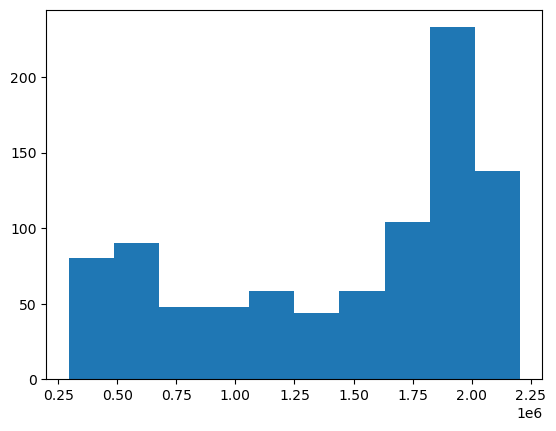

In [29]:
plt.hist(sums)

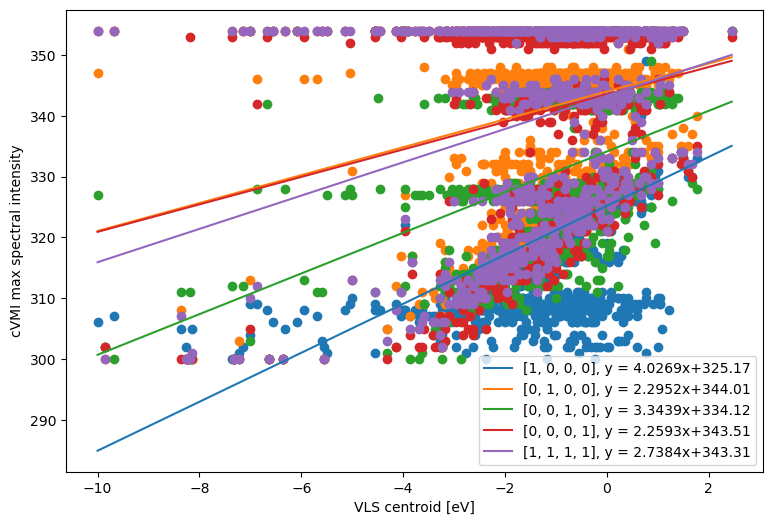

In [30]:
fig,axs = plt.subplots(figsize = (9,6))
#look_eVs = np.hstack((410, look_eVs))
#rrs = np.vstack((np.zeros(4),rrs))
#nns = np.hstack((0.1,nns))
for j, qfilter in enumerate(quadrant_filters):
    rplot = rrs[:,j]
    eVplot = nns #look_eVs #[ind]
    ind = np.argsort(eVplot)
    eVplot= eVplot[ind]
    rplot = rplot[ind]
    
    
    plt.scatter(eVplot, rplot) #, alpha = alphas)
    #plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
    #m,b,c = np.polyfit(eVplot, rplot, 2)
    m,b = np.polyfit(eVplot, rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    #plt.plot(eV,m*eV**2+b*eV+c, label = str(qfilter) + ', y = %1.4fx^2+%1.2fx+%1.2f' %(m,b,c))
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))

plt.xlabel('VLS centroid [eV]')
plt.ylabel('cVMI max spectral intensity')
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

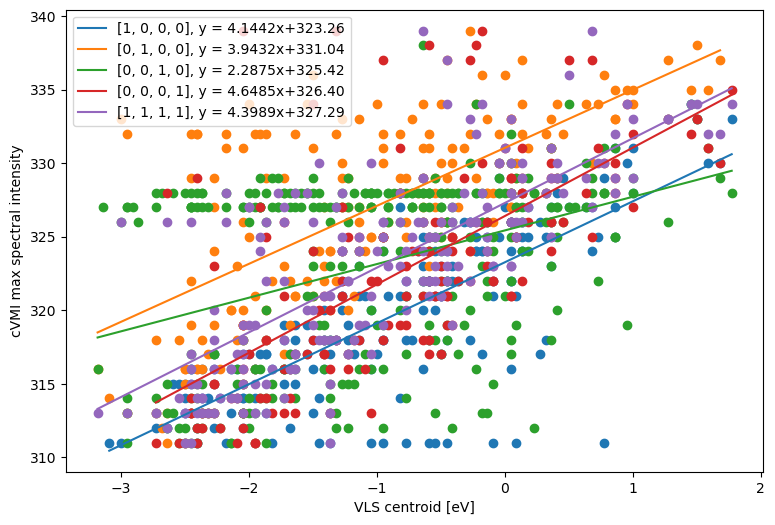

In [31]:
fig,axs = plt.subplots(figsize = (9,6))
#look_eVs = np.hstack((410, look_eVs))
#rrs = np.vstack((np.zeros(4),rrs))
#nns = np.hstack((0.1,nns))
for j, qfilter in enumerate(quadrant_filters):
    rplot = rrs[:,j]
    eVplot = nns #look_eVs #[ind]
    ind = np.argsort(eVplot)
    eVplot= eVplot[ind]
    rplot = rplot[ind]
    inds = (eVplot>-3.25) & (rplot<340) &  (rplot>310) & (sums> 1.3e6) & (maxes > 16)
    rplot = rplot[inds]
    eVplot = eVplot[inds]
    
    
#     rplot = rplot[eVplot>-3.25]
#     eVplot = eVplot[eVplot>-3.25]
    
#     eVplot = eVplot[rplot<350]
#     rplot = rplot[rplot<350]
    
    
    
    plt.scatter(eVplot, rplot) #, alpha = alphas)
    #plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
    #m,b,c = np.polyfit(eVplot, rplot, 2)
    m,b = np.polyfit(eVplot, rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    #plt.plot(eV,m*eV**2+b*eV+c, label = str(qfilter) + ', y = %1.4fx^2+%1.2fx+%1.2f' %(m,b,c))
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))

plt.xlabel('VLS centroid [eV]')
plt.ylabel('cVMI max spectral intensity')
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

In [50]:
def quadratic(x, a):
    return a*x**2


def quadratic_fit(r,eV):
    #spec = Et*Et.conj()
    popt, pcov = curve_fit(quadratic,r,eV, bounds=([0.00000000001], [10]))
    a = popt
    return a #FWHM is 2.355*sig


In [2]:
j = -2
rplot = rrs[:,j]
eVplot = nns #look_eVs #[ind]
ind = np.argsort(eVplot)
eVplot= eVplot[ind]
rplot = rplot[ind]
inds = (eVplot>-3.25) & (rplot<340) &  (rplot>310) & (sums> 1.3e6) & (maxes > 16)
rplot = np.hstack(([0],rplot[inds]))
eVplot = np.hstack(([0],36+eVplot[inds]))


#     rplot = rplot[eVplot>-3.25]
#     eVplot = eVplot[eVplot>-3.25]

#     eVplot = eVplot[rplot<350]
#     rplot = rplot[rplot<350]



plt.plot(rplot, eVplot,'.') #, alpha = alphas)
#plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
#m,b,c = np.polyfit(eVplot, rplot, 2)
a = quadratic_fit(rplot,eVplot)
rs = np.linspace(rplot[0],rplot[-1], 40)
plt.plot(rs,quadratic(rs, a), label = str(qfilter) + ', y = %1.9f(x[pix])^2' %(a))


plt.ylabel('VLS centroid [eV]')
plt.xlabel('cVMI max spectral intensity (cropped pix)')
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

NameError: name 'rrs' is not defined

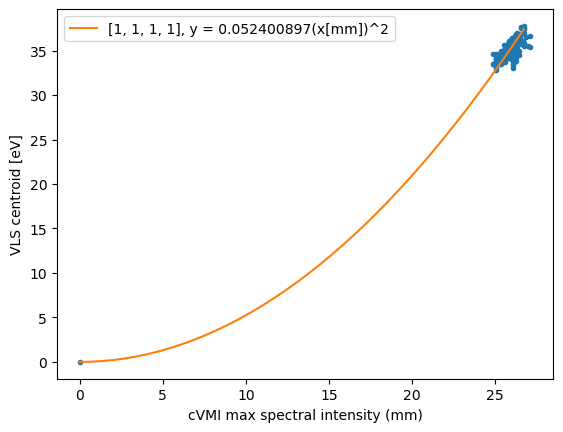

In [72]:
j = -1
rplot = rrs[:,j]
eVplot = nns #look_eVs #[ind]
ind = np.argsort(eVplot)
eVplot= eVplot[ind]
rplot = rplot[ind]
inds = (eVplot>-3.25) & (rplot<340) &  (rplot>310) & (sums> 1.3e6) & (maxes > 16)
rplot = np.hstack(([0],rplot[inds]))*40/500
eVplot = np.hstack(([0],36+eVplot[inds]))


#     rplot = rplot[eVplot>-3.25]
#     eVplot = eVplot[eVplot>-3.25]

#     eVplot = eVplot[rplot<350]
#     rplot = rplot[rplot<350]



plt.plot(rplot, eVplot,'.') #, alpha = alphas)
#plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
#m,b,c = np.polyfit(eVplot, rplot, 2)
a = quadratic_fit(rplot,eVplot)
rs = np.linspace(rplot[0],rplot[-1], 40)
plt.plot(rs,quadratic(rs, a), label = str(qfilter) + ', y = %1.9f(x[mm])^2' %(a))


plt.ylabel('VLS centroid [eV]')
plt.xlabel('cVMI max spectral intensity (mm)')
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

In [74]:
0.000335*512**2/27.2

3.2286117647058825

In [75]:
0.0005*498**2/27.2

4.55889705882353

(0.0, 100.0)

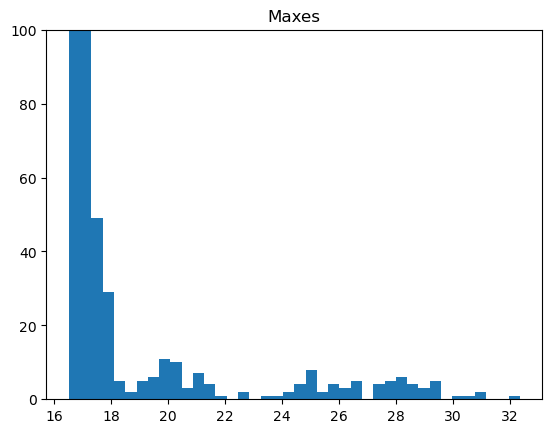

In [233]:
plt.hist(maxes,bins = 40)
plt.title('Maxes')
plt.ylim(0,100)

In [24]:
y = np.array(centroid)
corcen = np.zeros((nn,nn))
for i in range(nn): #np.arange(150, 850): #range(1024):
    for j in range(nn): #np.arange(150,850): #in range(1024):
        try: 
            x = np.array(imsM[:,i,j]) 
            corcen[i,j] = np.corrcoef(x,y)[0,1]
        except:
            corcen[i,j] = 0

/cds/sw/ds/ana/conda2/inst/envs/ps-4.5.23/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda2/inst/envs/ps-4.5.23/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


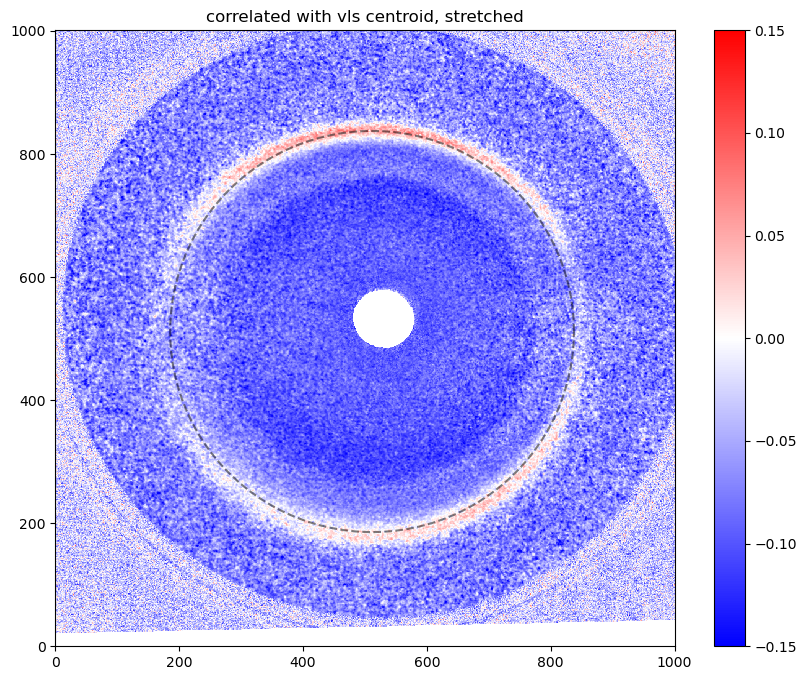

In [29]:
fig,axs = plt.subplots(figsize = (10,8))
toplot = np.copy(corcen)
#toplot[toplot<0] = np.nan
plt.pcolormesh(toplot, cmap = 'bwr', vmin = -0.15, vmax = 0.15)
#plt.plot(512,870,'ro')
#plotring()
plt.colorbar()
#plt.title('vls pix = 400')
#plt.title('vls sum')
plt.title('correlated with vls centroid, stretched')
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(511.5+ 326*np.cos(phis), 511.5+ 326*np.sin(phis), 'k--', alpha = 0.5)

#plt.plot(np.arange(515,520),484+np.arange(280,285), 'r.')
#plt.title('centroid')
# plotring(r= 270, col = 'w')
# plotring(r= 310, col = 'w')

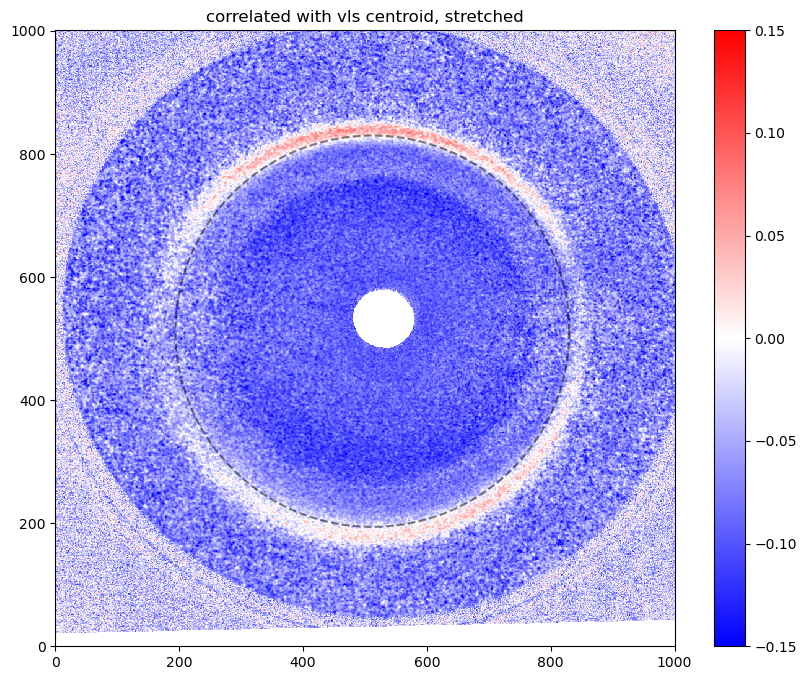

In [43]:
fig,axs = plt.subplots(figsize = (10,8))
toplot = np.copy(corcen)
#toplot[toplot<0] = np.nan
plt.pcolormesh(toplot, cmap = 'bwr', vmin = -0.15, vmax = 0.15)
#plt.plot(512,870,'ro')
#plotring()
plt.colorbar()
#plt.title('vls pix = 400')
#plt.title('vls sum')
plt.title('correlated with vls centroid, stretched')
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(512+ 318*np.cos(phis), 512+ 318*np.sin(phis), 'k--', alpha = 0.5)

#plt.plot(np.arange(515,520),484+np.arange(280,285), 'r.')
#plt.title('centroid')
# plotring(r= 270, col = 'w')
# plotring(r= 310, col = 'w')

464 499


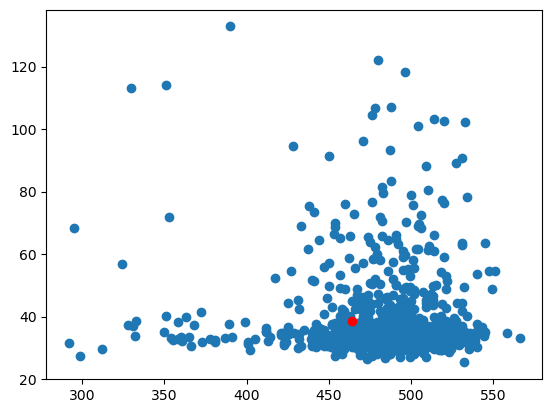

In [68]:
x = np.array(imsM[:,650,200]) 
plt.plot(y, x, 'o')
plt.plot(get_centroidish(x), np.mean(x), 'ro') 
print(get_centroidish(x),get_centroidish(y))

(array([662., 212.,  50.,  33.,  21.,   6.,   5.,   7.,   4.,   1.]),
 array([ 25.31054688,  36.06054688,  46.81054688,  57.56054688,
         68.31054688,  79.06054688,  89.81054688, 100.56054688,
        111.31054688, 122.06054688, 132.81054688]),
 <BarContainer object of 10 artists>)

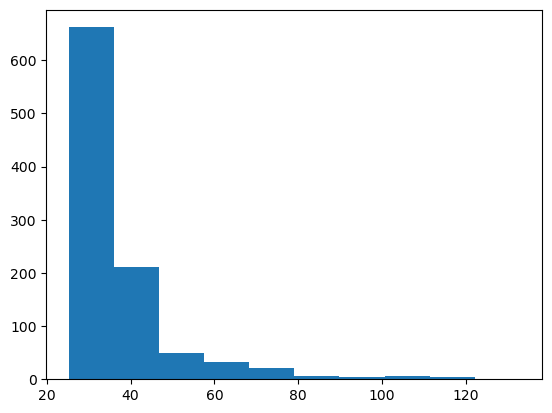

In [71]:
plt.hist(x)

In [79]:
eVcorltd = np.zeros((nn,nn))
for i in range(nn): #np.arange(150, 850): #range(1024):
    for j in range(nn): #np.arange(150,850): #in range(1024):
        try: 
            x = np.array(imsM[:,i,j]) 
            eVcorltd[i,j] = get_centroidish(x)
        except:
            eVcorltd[i,j] = 0

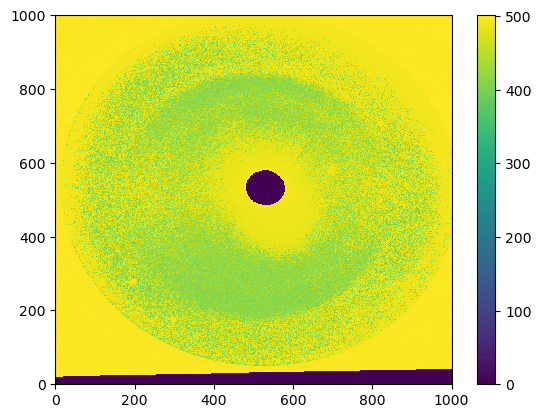

In [82]:
plt.pcolormesh(eVcorltd)
plt.colorbar()

In [81]:
plt.plot(xeV, sss)

NameError: name 'sss' is not defined

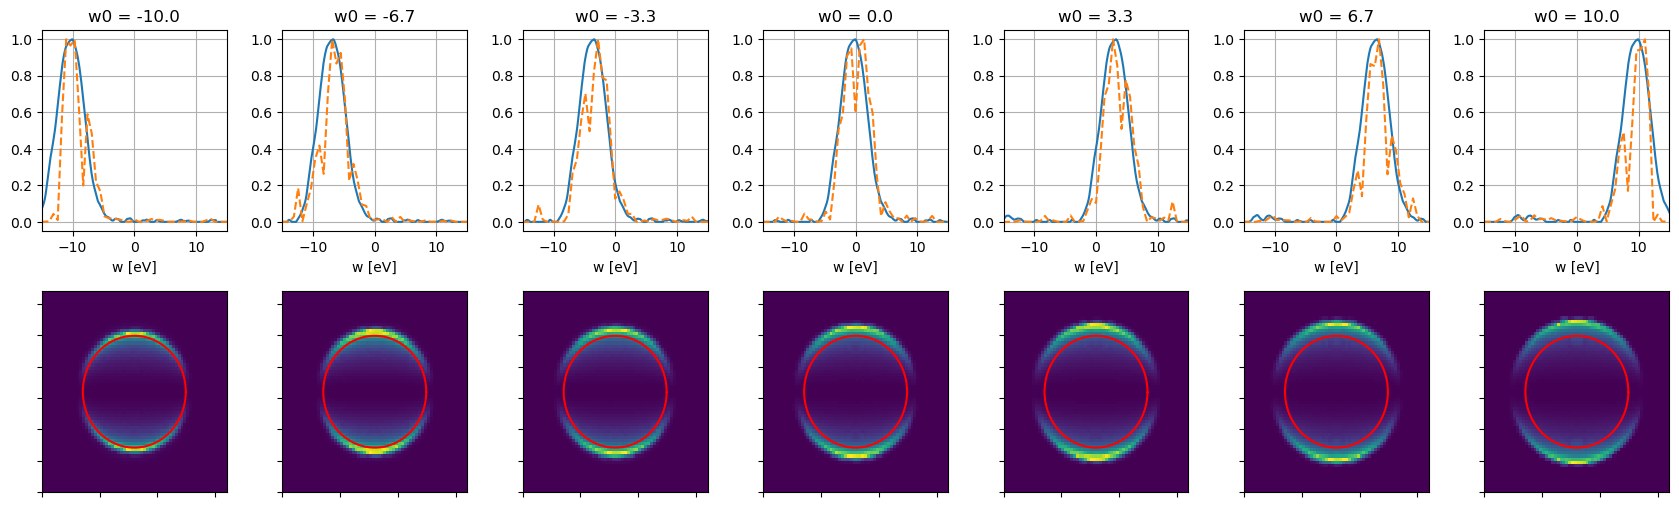

In [118]:
#check stuff
energy_x = 54
n = 7
ees = np.linspace(-10,10,n)

sss = fastsmooth1(specs[2],20)
sss[sss<0] = 0

fig,axs = plt.subplots(nrows = 2, ncols = n, figsize =(n*3, 2*3))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i in range(n):
    ee = ees[i]
    spec = np.sqrt(sss)  #sqrt of intensity spectra to get E(w)
    pp =1200
    spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
    N = len(spec)
    xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
    xeV = xeV + ee

    n1 = 0
    n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                    #also need it to be centered around where you are calling zero or there will be an offset
    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) #772
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)#4828 [386:2414]
    xeV = xeV[n1:n2] 
    spec = spec[n1:n2] 
    spec = np.fft.fftshift(spec)


    axs[0][i].plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')

    f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate')
    NN = 512*2
    NNN = 0
    N = len(spec)
    fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
    xeV = fx(np.linspace(0-NNN, N-1+NNN, NN))
    spec = f(xeV)
    xf = 2.9979E8*xeV/1239.84e-9

    f = xf[-1] - xf[0]
    N = len(spec)
    t = np.linspace(-N/f/2,N/f/2, N) 
    FFT = np.fft.fftshift(np.fft.fft(spec))


    car3 = np.exp(-1.j*(ee)/hbar*t)
    FFT = FFT*car3 #add in the frequency due to offset from zero frequency
    f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
    x = f(vNaxis['t_sample'])
    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

    Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


    Et = np.squeeze(np.matmul(Q.T,alpha_t))
    f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
    ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
    st = np.fft.ifftshift(np.fft.ifft(f(ts)))
    specc = st*np.conj(st)
    specc = specc/np.max(np.abs(specc))

    xf = np.arange(-N/2,N/2,1)/(ts[-1] - ts[0])  #Hz???
    xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

    axs[0][i].plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
    axs[0][i].set_xlim(-15,15)
    axs[0][i].set_title('w0 = %1.1f' %ee)
    axs[0][i].grid()
    axs[0][i].set_xlabel('w [eV]')
    axs[1][i].pcolormesh((np.reshape(Msol1, [64,64])))
    axs[1][i].set_xticklabels([])
    axs[1][i].set_yticklabels([])

    r = 285 #360
    binn = 32/2
    phi_rad = np.arange(0,360)*np.pi/180
    axs[1][i].plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')

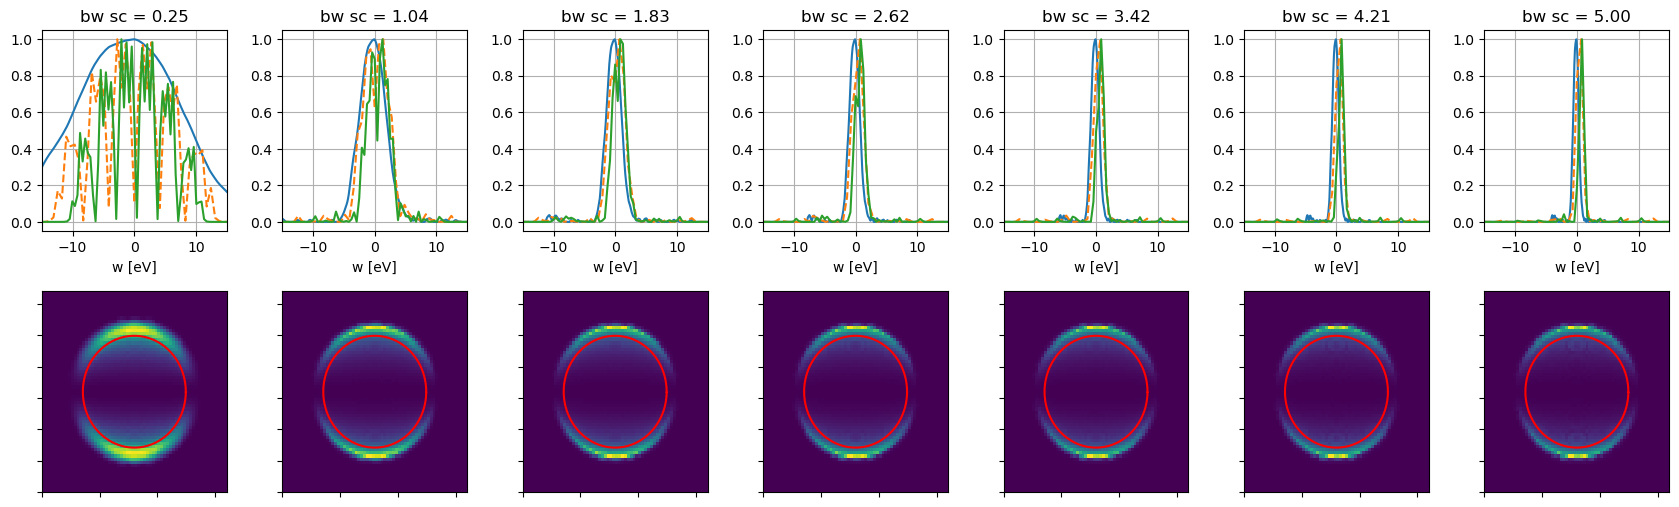

In [10]:
#check stuff
energy_x = 54
n = 7
scales = np.linspace(0.25, 5, n)
ee = 0
sss = fastsmooth1(specs[2],20)
sss[sss<0] = 0

check_ims = []

N = 2801
xf = np.arange(-N/2,N/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 

fig,axs = plt.subplots(nrows = 2, ncols = n, figsize =(n*3, 2*3))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i in range(n):
    ee = 0
    spec = np.sqrt(sss)  #sqrt of intensity spectra to get E(w)
    
    x1 = np.arange(len(sss))
    f = interpolate.interp1d(x1, spec, fill_value = 0, bounds_error = False)
    sc = scales[i] #3.5/5
    xs = np.linspace(sc*(x1[0] -np.argmax(spec)), sc*(x1[-1]-np.argmax(spec)), len(x1))+np.argmax(spec)
    spec = f(xs)
    
    pp =1200
    spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
    N = len(spec)
    xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
    xeV = xeV + ee

    n1 = 0
    n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                    #also need it to be centered around where you are calling zero or there will be an offset
    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) #772
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)#4828 [386:2414]
    xeV = xeV[n1:n2] 
    spec = spec[n1:n2] 
    xeV1 = np.copy(xeV)
    spec1 = np.copy(spec)
    spec = np.fft.fftshift(spec)


    axs[0][i].plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')

    f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate')
    NN = 512*2
    NNN = 0
    N = len(spec)
    fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
    xeV = fx(np.linspace(0-NNN, N-1+NNN, NN))
    spec = f(xeV)
    xf = 2.9979E8*xeV/1239.84e-9

    f = xf[-1] - xf[0]
    N = len(spec)
    t = np.linspace(-N/f/2,N/f/2, N) 
    FFT = np.fft.fftshift(np.fft.fft(spec))


    car3 = np.exp(-1.j*(ee)/hbar*t)
    FFT = FFT*car3 #add in the frequency due to offset from zero frequency
    f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
    x = f(vNaxis['t_sample'])
    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

    Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))
    

    Et = np.squeeze(np.matmul(Q.T,alpha_t))
    f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
    ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
    st = np.fft.ifftshift(np.fft.ifft(f(ts)))
    specc = st*np.conj(st)
    specc = specc/np.max(np.abs(specc))

    xf = np.arange(-N/2,N/2,1)/(ts[-1] - ts[0])  #Hz???
    xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

    axs[0][i].plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
    axs[0][i].set_xlim(-15,15)
    axs[0][i].set_title('bw sc = %1.2f' %sc)
    axs[0][i].grid()
    axs[0][i].set_xlabel('w [eV]')
    axs[1][i].pcolormesh((np.reshape(Msol1, [64,64])))
    check_ims.append(np.reshape(Msol1, [64,64]))
    axs[1][i].set_xticklabels([])
    axs[1][i].set_yticklabels([])
    
    Ew = np.squeeze(np.matmul(Q.T,alphw))
    EwEw = np.real(Ew*Ew.conj())
    EwEw = EwEw[1340:-1340]
    EwEw = EwEw/np.max(EwEw)
    axs[0][i].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'tab:green')
    
#     spec_in = spec1
#     f = interpolate.interp1d(xeV1, spec_in, fill_value = 0, bounds_error= False) #take out offset you put in before solving Q
#     Q = np.reshape(np.matmul(np.reshape(f(eV),[1,2801]), np.linalg.pinv(alphw)), [36,1])
#     Ew = np.squeeze(np.matmul(Q.T,alphw))
#     EwEw = np.real(Ew*Ew.conj())
#     EwEw = EwEw[1340:-1340]
#     EwEw = EwEw/np.max(EwEw)
#     axs[0][i].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'r')
    

    r = 285 #360
    binn = 32/2
    phi_rad = np.arange(0,360)*np.pi/180
    axs[1][i].plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')

(-10.0, 10.0)

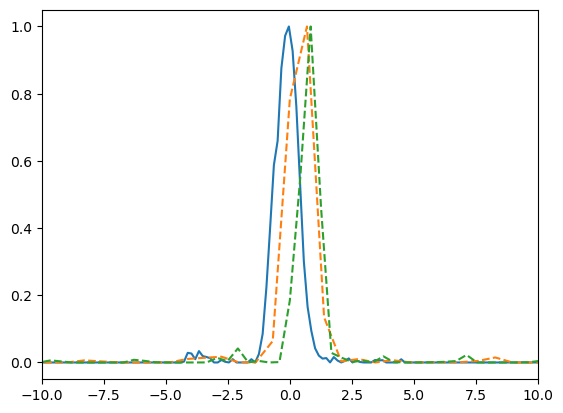

In [19]:
plt.plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')
plt.plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
Ew = np.squeeze(np.matmul(Q.T,alphw))
EwEw2 = np.real(Ew)**2+np.imag(Ew)**2
EwEw2 = EwEw2[1340:-1340]
EwEw2 = EwEw2/np.max(EwEw2)
plt.plot(np.linspace(eV[1340],eV[-1340], len(EwEw2)), np.squeeze(EwEw2), '--')
plt.xlim(-10,10)

In [144]:
64**2

4096

In [146]:
36**2

1296

In [150]:
np.matmul(Q,Q.conj().transpose()).transpose().shape

(36, 36)

In [149]:
np.matmul(Q,Q.conj().transpose()).transpose().flatten().shape

(1296,)

In [145]:
Q.shape

(36, 1)

In [143]:
Bp_basis.shape

(1296, 4096)

In [115]:
Q0 = np.zeros((36,1), complex)
Q0[20] = 1 + 1j
Q0[3] = 1 

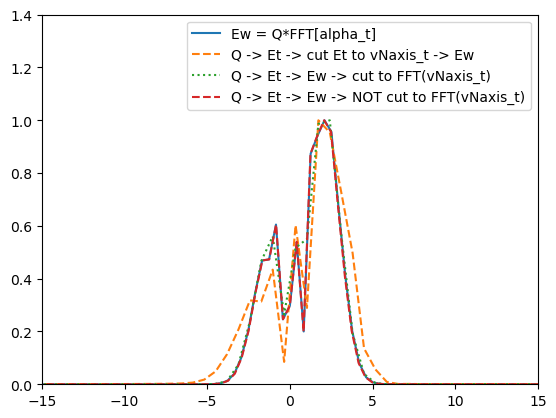

In [116]:
Ew = np.squeeze(np.matmul(Q0.T,alphw))
EwEw2 = np.real(Ew)**2+np.imag(Ew)**2
EwEw2 = EwEw2[1340:-1340]
EwEw2 = EwEw2/np.max(EwEw2)
eV0 = np.linspace(eV[1340],eV[-1340], len(EwEw2))
plt.plot(eV0, np.squeeze(EwEw2), '-', label = 'Ew = Q*FFT[alpha_t]')


Et = np.squeeze(np.matmul(Q0.T,alpha_t))
f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
st = np.fft.ifftshift(np.fft.ifft(f(ts)))
specc = st*np.conj(st)
specc = specc/np.max(np.abs(specc))

xf = np.arange(-N/2+1/2,N/2+1/2,1)/(ts[-1] - ts[0])  #Hz???
xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

plt.plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Q -> Et -> cut Et to vNaxis_t -> Ew')


Et = np.squeeze(np.matmul(Q0.T,alpha_t))
NN = len(Et) #2801
ts = np.linspace(vNaxis['t_sample'][0],vNaxis['t_sample'][-1], NN)
st = np.fft.ifftshift(np.fft.ifft(Et))
specc = st*np.conj(st)
specc = specc/np.max(np.abs(specc))

xxf = np.arange(-NN/2+1/2,NN/2+1/2,1)/(ts[-1] - ts[0])  #Hz???
xxxeV = 1239.84*(xxf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9
f = interpolate.interp1d(xxxeV, specc, fill_value = 'extrapolate') #take out offset you put in before solving Q
speccc = np.real(f(xxeV))
#speccc = np.real(f(eV0))
plt.plot(xxeV,speccc/np.max(speccc) , ':', label = 'Q -> Et -> Ew -> cut to FFT(vNaxis_t)')
plt.plot(xxxeV,specc, '--', label = 'Q -> Et -> Ew -> NOT cut to FFT(vNaxis_t)')
plt.xlim(-15,15)
plt.ylim(0,1.4)
plt.legend()

In [88]:
np.linspace(eV[1340],eV[-1340], len(EwEw2))

array([-25.14668811, -24.72757664, -24.30846517, -23.8893537 ,
       -23.47024223, -23.05113077, -22.6320193 , -22.21290783,
       -21.79379636, -21.37468489, -20.95557342, -20.53646196,
       -20.11735049, -19.69823902, -19.27912755, -18.86001608,
       -18.44090461, -18.02179314, -17.60268168, -17.18357021,
       -16.76445874, -16.34534727, -15.9262358 , -15.50712433,
       -15.08801287, -14.6689014 , -14.24978993, -13.83067846,
       -13.41156699, -12.99245552, -12.57334405, -12.15423259,
       -11.73512112, -11.31600965, -10.89689818, -10.47778671,
       -10.05867524,  -9.63956378,  -9.22045231,  -8.80134084,
        -8.38222937,  -7.9631179 ,  -7.54400643,  -7.12489496,
        -6.7057835 ,  -6.28667203,  -5.86756056,  -5.44844909,
        -5.02933762,  -4.61022615,  -4.19111468,  -3.77200322,
        -3.35289175,  -2.93378028,  -2.51466881,  -2.09555734,
        -1.67644587,  -1.25733441,  -0.83822294,  -0.41911147,
         0.        ,   0.41911147,   0.83822294,   1.25

In [137]:
xxf = np.arange(-NN/2+1/2,NN/2+1/2,1)/(ts[-1] - ts[0])  #Hz???
xxxeV = 1239.84*(xxf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

array([-5.85833333e-17, -5.55000000e-17, -5.24166667e-17, -4.93333333e-17,
       -4.62500000e-17, -4.31666667e-17, -4.00833333e-17, -3.70000000e-17,
       -3.39166667e-17, -3.08333333e-17, -2.77500000e-17, -2.50000000e-17,
       -2.46666667e-17, -2.15833333e-17, -1.85000000e-17, -1.54166667e-17,
       -1.23333333e-17, -9.25000000e-18, -6.16666667e-18, -3.08333333e-18,
        2.99767144e-28,  3.08333333e-18,  6.16666667e-18,  9.25000000e-18,
        1.23333333e-17,  1.54166667e-17,  1.85000000e-17,  2.15833333e-17,
        2.46666667e-17,  2.50000000e-17])

array([-1.65507190e-39-4.83892148e-40j, -8.68128749e-39-1.14916281e-39j,
       -4.38054934e-38+9.29997904e-40j, ...,
        8.55812435e-08+1.05990366e-07j,  6.75639487e-08+8.65190210e-09j,
        2.69788500e-08-1.99534534e-08j])

In [50]:
f(ts)

array([-1.47090773e-16-8.45126381e-17j, -1.67926347e-16-9.25141989e-17j,
       -1.91584909e-16-1.01110726e-16j, ...,
       -1.51410760e-02-6.02186481e-01j, -6.79356090e-02-5.89864278e-01j,
       -1.18664404e-01-5.73008708e-01j])

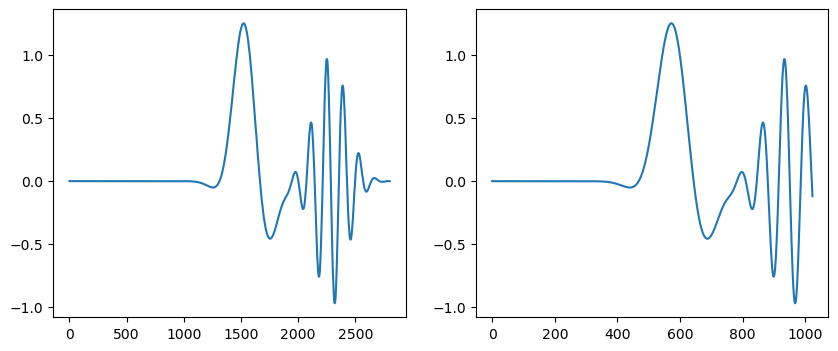

In [54]:
fig,axs = plt.subplots(nrows=1,ncols =2,figsize=(10,4))
axs[0].plot(Et)
axs[1].plot(f(ts))

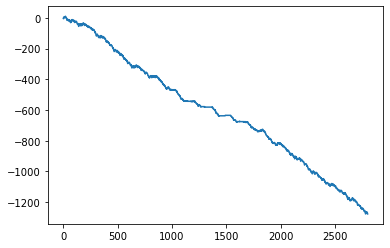

In [61]:
plt.plot(np.unwrap(np.angle(Ew)))

(-14.0, 14.0)

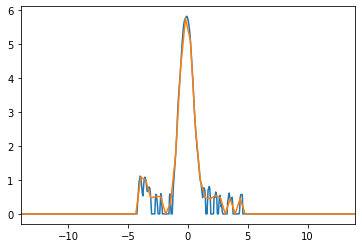

In [37]:
plt.plot(xeV1, spec1)
plt.plot(eV, f(eV))
plt.xlim(-14,14)

In [57]:
zz = spec1*np.exp(1j*np.linspace(0,np.pi, len(spec1)))

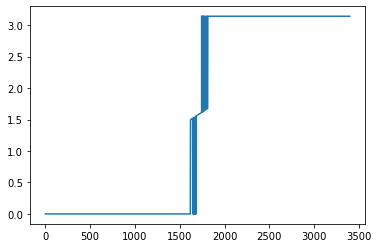

In [58]:
plt.plot(np.unwrap(np.angle(zz)))

In [40]:
np.reshape(f(eV),[1,2801]).shape

(1, 2801)

In [39]:
np.linalg.pinv(alphw).shape

(2801, 36)

In [41]:
Q = np.reshape(np.matmul(np.reshape(f(eV),[1,2801]), np.linalg.pinv(alphw)), [36,1])

In [22]:
alphw.shape

(36, 2801)

In [25]:
alpha_t.shape

(36, 2801)

In [27]:
vNaxis['t_sample'].shape

(2801,)

In [28]:
eV.shape

(2801,)

In [29]:
spec.shape

(1024,)

In [128]:
for i in range(len(check_ims)):
    print(np.sum(check_ims[i]))

455940999681.4675
156637283705.36133
93187095650.82281
66201254009.714806
51075478568.74972
40852444335.085335
34865772144.415146


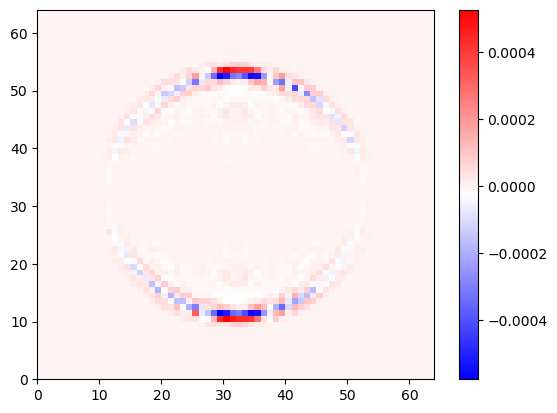

In [136]:
a = 1
b = 2
plt.pcolormesh(check_ims[a]/np.sum(check_ims[a]) - check_ims[b]/np.sum(check_ims[b]), cmap = 'bwr')
plt.colorbar()

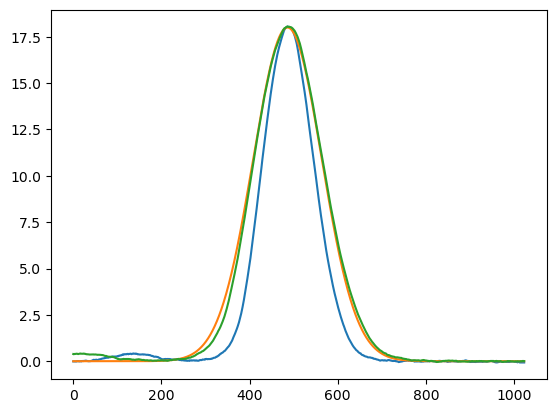

In [279]:
sss = np.mean(specs, axis = 0) #ss[0:20,:]
plt.plot(sss)
x = np.arange(len(sss))
#um = 22*np.exp(-((x-np.argmax(sss))/10)**2)
um = 18*np.exp(-((x-np.argmax(sss))/110)**2)
#um = 22*np.exp(-((x-np.argmax(sss))/100)**2)
plt.plot(um)
x1 = np.arange(len(sss))
f = interpolate.interp1d(x1, sss, fill_value = 0, bounds_error = False)
sc = 3.5/4.7
xs = np.linspace(sc*(x1[0] -np.argmax(sss)), sc*(x1[-1]-np.argmax(sss)), len(x1))+np.argmax(sss)
plt.plot(f(xs))

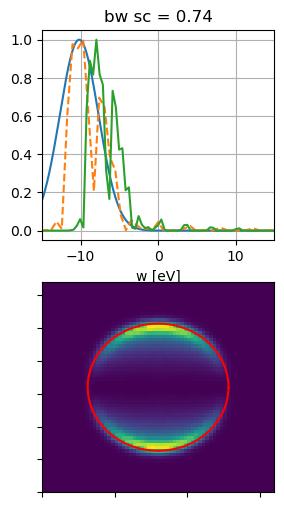

In [92]:
spec = um
ee = -9
    
fig,axs = plt.subplots(nrows = 2, ncols = 1, figsize =(3, 2*3))
N = 2801
xf = np.arange(-N/2,N/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
pp =1200
spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
N = len(spec)
xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
xeV = xeV + ee

n1 = 0
n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                #also need it to be centered around where you are calling zero or there will be an offset
t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) #772
t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)#4828 [386:2414]
xeV = xeV[n1:n2] 
spec = spec[n1:n2] 
xeV1 = np.copy(xeV)
spec1 = np.copy(spec)
spec = np.fft.fftshift(spec)


axs[0].plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')

f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate')
NN = 512*2
NNN = 0
N = len(spec)
fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
xeV = fx(np.linspace(0-NNN, N-1+NNN, NN))
spec = f(xeV)
xf = 2.9979E8*xeV/1239.84e-9

f = xf[-1] - xf[0]
N = len(spec)
t = np.linspace(-N/f/2,N/f/2, N) 
FFT = np.fft.fftshift(np.fft.fft(spec))


car3 = np.exp(-1.j*(ee)/hbar*t)
FFT = FFT*car3 #add in the frequency due to offset from zero frequency
f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
x = f(vNaxis['t_sample'])
alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


Et = np.squeeze(np.matmul(Q.T,alpha_t))
f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
st = np.fft.ifftshift(np.fft.ifft(f(ts)))
specc = st*np.conj(st)
specc = specc/np.max(np.abs(specc))

xf = np.arange(-N/2,N/2,1)/(ts[-1] - ts[0])  #Hz???
xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

axs[0].plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
axs[0].set_xlim(-15,15)
axs[0].set_title('bw sc = %1.2f' %sc)
axs[0].grid()
axs[0].set_xlabel('w [eV]')
axs[1].pcolormesh((np.reshape(Msol1, [64,64])))
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

Ew = np.squeeze(np.matmul(Q.T,alphw))
EwEw = np.real(Ew*Ew.conj())
EwEw = EwEw[1340:-1340]
EwEw = EwEw/np.max(EwEw)
axs[0].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'tab:green')

#     spec_in = spec1
#     f = interpolate.interp1d(xeV1, spec_in, fill_value = 0, bounds_error= False) #take out offset you put in before solving Q
#     Q = np.reshape(np.matmul(np.reshape(f(eV),[1,2801]), np.linalg.pinv(alphw)), [36,1])
#     Ew = np.squeeze(np.matmul(Q.T,alphw))
#     EwEw = np.real(Ew*Ew.conj())
#     EwEw = EwEw[1340:-1340]
#     EwEw = EwEw/np.max(EwEw)
#     axs[0][i].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'r')


r = 310 #looks like centroid of points is around 310 pix #360
binn = 32/2
phi_rad = np.arange(0,360)*np.pi/180
axs[1].plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')

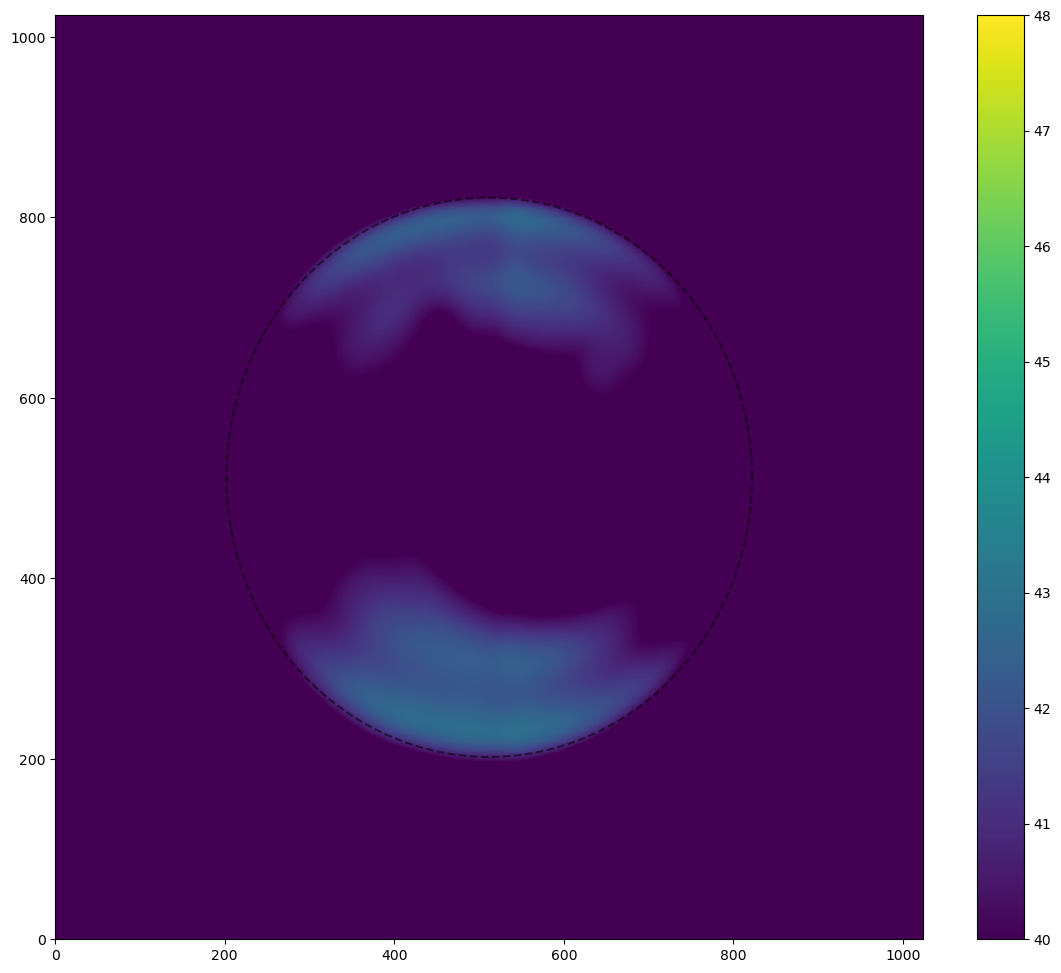

In [85]:
plt.figure(figsize = (14,12))
plt.pcolormesh(gf(mf(quads2*np.mean(imsM,axis = 0),20),10), vmin = 40, vmax = 48)
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(512+ 310*np.cos(phis), 512+ 310*np.sin(phis), 'k--', alpha = 0.5)
plt.colorbar()

In [284]:
gfsig = 0. #0.9 
Ups = [0]
Bps = []
alphas = []
vNaxiss = []
alphaws = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
    print(filename)
    br = np.load(basesdir+filename, allow_pickle=True)
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    breal = br[()]['breal']
    bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    tempr = np.zeros((Breal.shape[0], 64**2))
    tempi = np.zeros((Breal.shape[0], 64**2))
    for i in range(len(Breal)):
        tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
        tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

    Breal = tempr
    Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        alphw[i] = np.fft.ifftshift(np.fft.ifft(alpha['t_sample'][i]))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)

Bpbasis_Np128_Nw6_Nt6_Up0.npy


/tmp/ipykernel_29592/561546331.py:42: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
/tmp/ipykernel_29592/561546331.py:49: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))


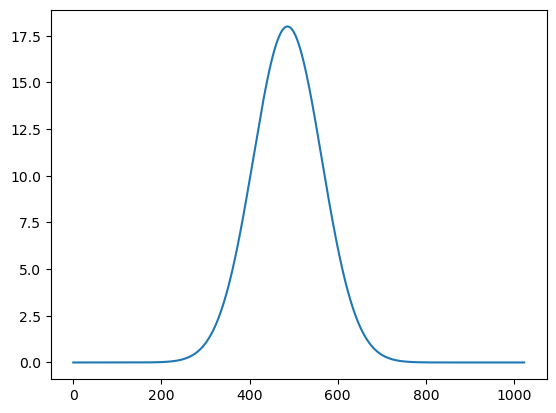

In [281]:
plt.plot(um)

In [288]:
n = 30

tocorim = []
tocoreV = []

quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]]
ees = np.linspace(-9,9,n) #370,420
rrs0 = np.zeros((n,len(quadrant_filters)))
r1=260
r2 = 400
x0 = 512
y0 = 512

sss = um

for i in range(n):
    ee = ees[i]
    
    sss = fastsmooth1(sss,10)
    sss[sss<0] = 0

    spec = np.sqrt(sss)  #sqrt of intensity spectra to get E(w)
    pp =1200
    spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
    N = len(spec)
    xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
    xeV = xeV + ee

    n1 = 0
    n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                    #also need it to be centered around where you are calling zero or there will be an offset
    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)
    xeV = xeV[n1:n2]
    spec = spec[n1:n2] 
    spec = np.fft.fftshift(spec)

    f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate') #xeV is evenly spaced so this should be fine

    #sample more points from the relevant region
    NN = 1024
    NNN = 0
    N = len(spec)
    fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
    xeV = fx(np.linspace(0-NNN, N-1+NNN, NN)) 
    spec = f(xeV) #evenly spaced
    xf = 2.9979E8*xeV/1239.84e-9

    f = xf[-1] - xf[0]
    N = len(spec)
    t = np.linspace(-N/f/2,N/f/2, N) 

    FFT = np.fft.fftshift(np.fft.fft(spec))
    car3 = np.exp(-1.j*(ee)/hbar*t)
    FFT = FFT*car3 #add in the frequency due to offset from zero frequency

    f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
    x = f(vNaxis['t_sample'])
    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

    Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


    #Msol1 =  make_bg_fixed(sss, ee, vNaxis0, alpha0, Bp_basis0, vls_pitch = 5.399977, order = 3)
    Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
    ii = cv2.resize(np.rot90(Msol1), (1024,1024), interpolation = cv2.INTER_AREA)
    
    for j, qfilter in enumerate(quadrant_filters):
        
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
        
        centroid = get_centroidish(spec_to_plot[r1:r2])
        rrs0[i,j] = ke_calib(np.arange(r1,r2))[centroid]
    
        #rrs0[i,j] = ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])]
    tocorim.append(ii)
    tocoreV.append(centroid)

         
    print(rrs0[i,:])

[306. 307. 307. 306. 306.]
[308. 308. 308. 307. 308.]
[309. 310. 310. 309. 309.]
[311. 312. 312. 310. 311.]
[313. 314. 313. 312. 313.]
[315. 315. 315. 314. 315.]
[317. 317. 317. 316. 317.]
[319. 319. 319. 318. 319.]
[321. 321. 321. 320. 321.]
[323. 324. 323. 322. 323.]
[325. 326. 325. 324. 325.]
[327. 328. 328. 327. 327.]
[329. 330. 330. 329. 329.]
[331. 332. 332. 331. 332.]
[334. 334. 333. 333. 334.]
[336. 336. 336. 335. 336.]
[337. 338. 338. 337. 338.]
[340. 340. 340. 339. 340.]
[342. 343. 342. 341. 342.]
[344. 345. 344. 343. 344.]
[346. 347. 346. 345. 346.]
[348. 348. 348. 347. 348.]
[350. 350. 350. 349. 349.]
[351. 352. 351. 351. 351.]
[353. 354. 353. 352. 353.]
[354. 355. 355. 354. 355.]
[356. 357. 356. 355. 356.]
[358. 358. 357. 357. 358.]
[359. 360. 359. 358. 359.]
[360. 361. 360. 359. 360.]


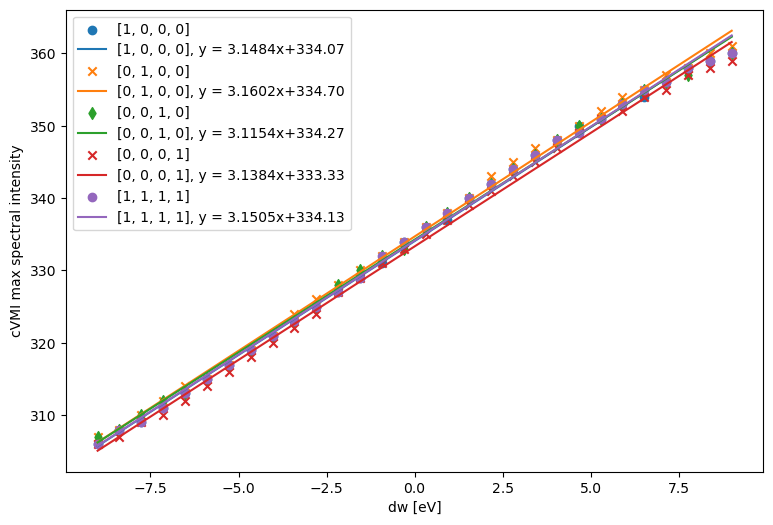

In [287]:
fig,axs = plt.subplots(figsize = (9,6))
plotstyle = ['o', 'x', 'd', 'x', 'o']
for j, qfilter in enumerate(quadrant_filters):
    plt.scatter(ees, rrs0[:,j], marker = plotstyle[j%5], label = qfilter)
    rplot = rrs0[:,j]
    eVplot = ees
    m,b = np.polyfit(eVplot,rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))
plt.xlabel('dw [eV]')
plt.ylabel('cVMI max spectral intensity')
plt.legend()

In [292]:

tocorim = np.array(tocorim)
y = np.array(tocoreV)
corcen = np.zeros((1024,1024))
for i in range(nn): #np.arange(150, 850): #range(1024):
    for j in range(nn): #np.arange(150,850): #in range(1024):
        try:
            x = np.array(tocorim[:,i,j])       
            corcen[i,j] = np.corrcoef(x,y)[0,1]
        except:
            corcen[i,j] = 0

/cds/sw/ds/ana/conda2/inst/envs/ps-4.5.23/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda2/inst/envs/ps-4.5.23/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'simulated correlated with simulated centroid')

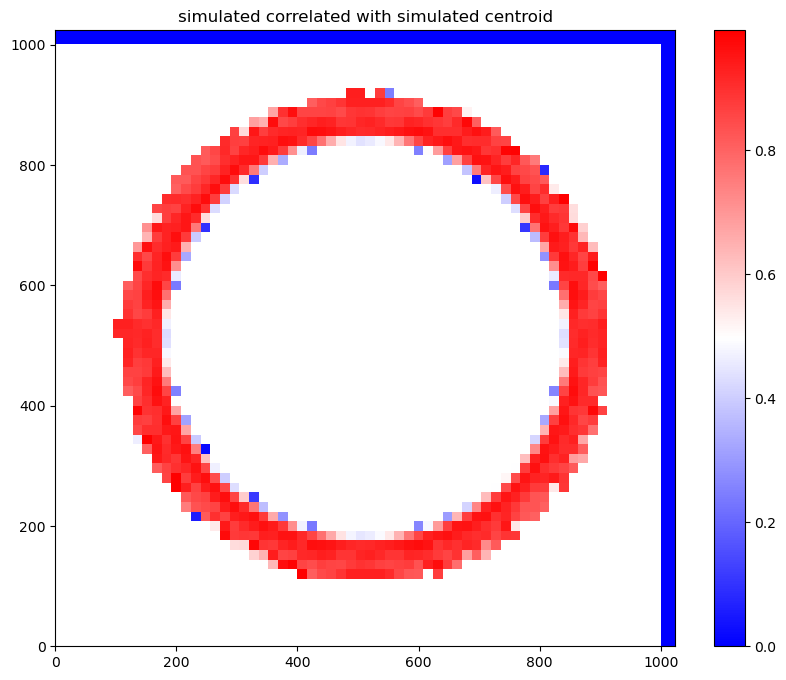

In [293]:
fig,axs = plt.subplots(figsize = (10,8))
toplot = np.copy(corcen)
toplot[toplot<0] = np.nan
plt.pcolormesh(toplot, cmap = 'bwr') #, vmin = 0, vmax = 0.2)
#plt.plot(512,870,'ro')
#plotring()
plt.colorbar()
#plt.title('vls pix = 400')
#plt.title('vls sum')
plt.title('simulated correlated with simulated centroid')
#plt.plot(np.arange(515,520),484+np.arange(280,285), 'r.')
#plt.title('centroid')
# plotring(r= 270, col = 'w')
# plotring(r= 310, col = 'w')

Text(0.5, 1.0, 'simulated correlated with simulated centroid')

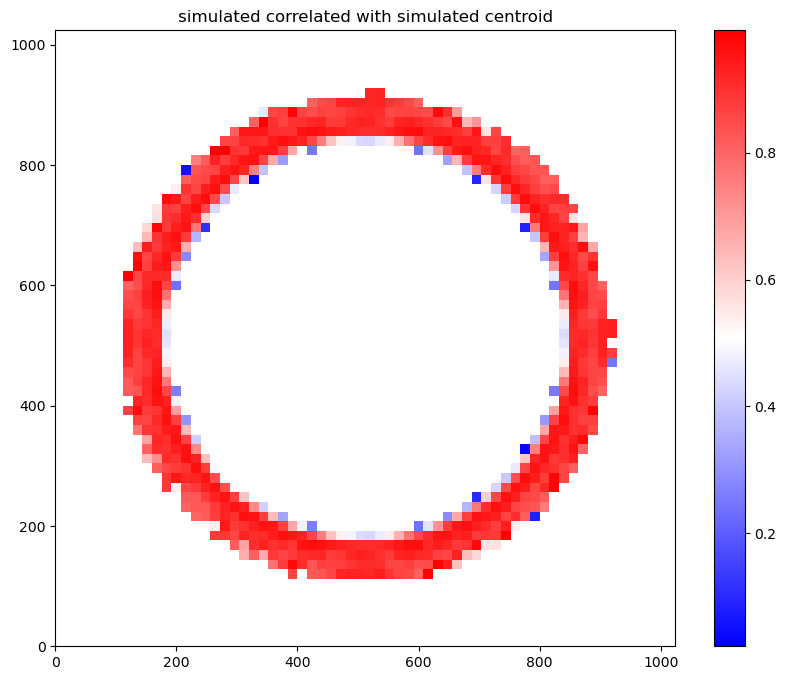

In [309]:
fig,axs = plt.subplots(figsize = (10,8))
toplot = np.copy(corcen)#[100:924,100:924]
toplot[toplot<0.001] = np.nan
plt.pcolormesh(np.rot90(toplot), cmap = 'bwr') #, vmin = 0, vmax = 0.2)
#plt.plot(512,870,'ro')
#plotring()
plt.colorbar()
#plt.title('vls pix = 400')
#plt.title('vls sum')
plt.title('simulated correlated with simulated centroid')
#plt.plot(np.arange(515,520),484+np.arange(280,285), 'r.')
#plt.title('centroid')
# plotring(r= 270, col = 'w')
# plotring(r= 310, col = 'w')

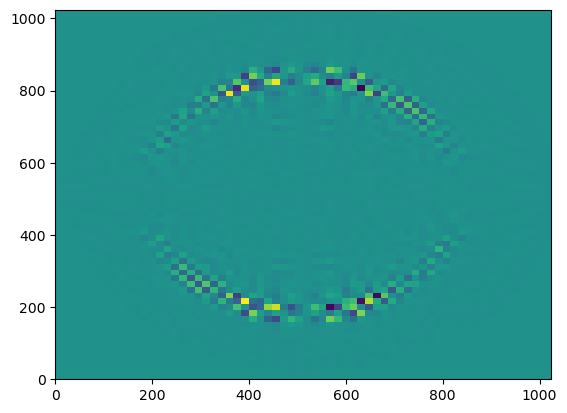

In [302]:
plt.pcolormesh(np.rot90(tocorim[10]-np.flip(tocorim[10])))


In [35]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
#maskhm[(rs>325) & (rs<420)]=1
maskhm[(rs>325-42/2) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)

In [92]:
1024/16

64.0

In [101]:
3.5*12

42.0

In [100]:
3.5*10/16

2.1875

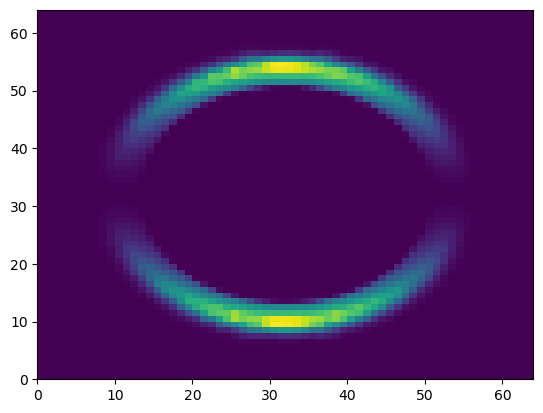

In [103]:
plt.pcolormesh(Msol1*mask)



In [260]:
ims_bg[0].shape

(1024, 1024)

In [36]:
pp =  cv2.warpPerspective(ims_bg[0]*quads2,MM,(1024,1024))

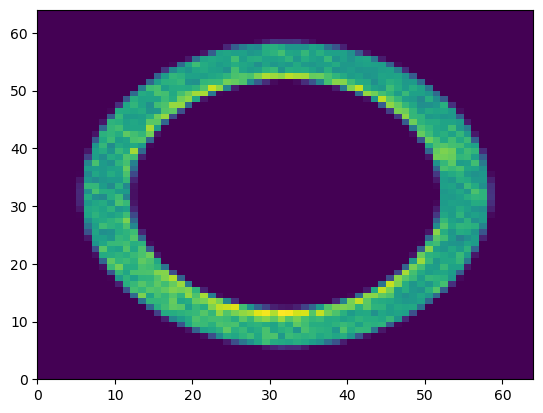

In [267]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>320) & (rs<420)]=1
#maskhm[(rs>325) & (rs<420)]=1
#maskhm[(rs>325-42/2) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)
plt.pcolormesh(rebin(rebin(pp,4),4)*mask)

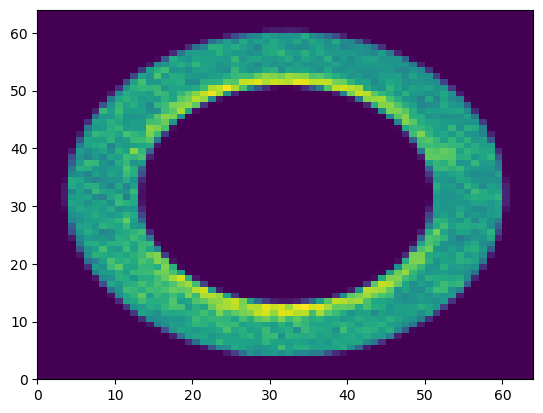

In [269]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
#maskhm[(rs>325) & (rs<420)]=1
maskhm[(rs>325-42/2) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)
plt.pcolormesh(rebin(rebin(pp,4),4)*mask)

In [39]:
325-42/2

304.0

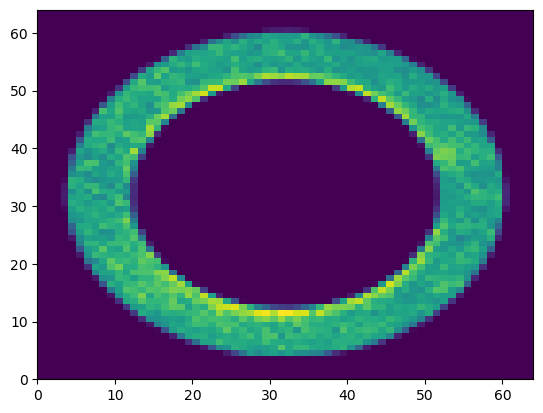

In [45]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>318) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)
plt.pcolormesh(rebin(rebin(pp,4),4)*mask)

In [193]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]]
ees = np.zeros(36) #370,420
rrs0 = np.zeros((36,len(quadrant_filters)))
r1=260
r2 = 400
x0 = 512
y0 = 512
ke_calib = lambda x: x 

In [194]:
Msol1 = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Msol6.npy')
Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
ii = cv2.resize(np.rot90(Msol1), (1024,1024), interpolation = cv2.INTER_AREA)

for j, qfilter in enumerate(quadrant_filters):

    folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
    out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

    ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
    betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
    spec_to_plot = ints[0] if len(ints.shape)==2 else ints

    centroid = get_centroidish(spec_to_plot[r1:r2])
    rrs0[j] = ke_calib(np.arange(r1,r2))[centroid]
    

print(rrs0)
print(np.mean(rrs0))

[327. 327. 327. 326. 327.]
326.8


Text(0.5, 1.0, 'Msol6 pBasex max pix = 326.8')

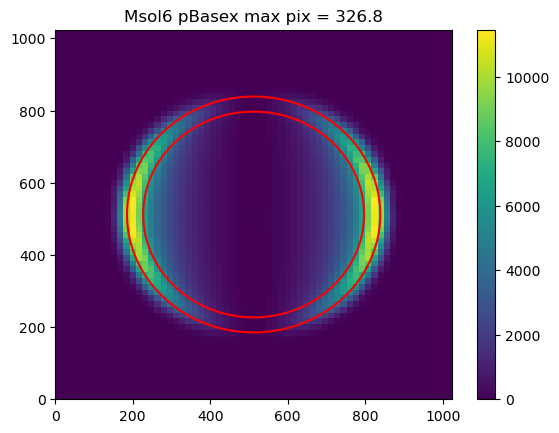

In [197]:
plt.pcolormesh(ii)
plt.colorbar()
r = 285
binn = 1
phi_rad = np.arange(0,360)*np.pi/180
plt.plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')
r = 326.8
binn = 1
phi_rad = np.arange(0,360)*np.pi/180
plt.plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')
plt.title('Msol6 pBasex max pix = %1.1f' %np.mean(rrs0))

In [228]:
n = 4

tocorim = []
tocoreV = []

quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]]
ees = np.zeros(n) #370,420
rrs0 = np.zeros((n,len(quadrant_filters)))
r1=260
r2 = 400
x0 = 512
y0 = 512

for i in range(n):
    
    Q = np.zeros((36,1), complex)
    Q[i] = (-0.7+0.5j)
    Q[i+1] = (0.8-0.5j)
    Q[i+2] = (-0.7+0.5j)
    
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))

    
    N = 2801
    xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
    eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
    Ew = np.squeeze(np.matmul(Q.T,alphw))
    EwEw = np.real(Ew*Ew.conj())
    EwEw = EwEw[1340:-1340]
    EwEw = EwEw/np.max(EwEw)
    #ees[i] = eV[1340:-1340][np.argmax(EwEw)]
    ees[i] = eV[1340:-1340][get_centroidish(EwEw)]
    
    #Msol1 =  make_bg_fixed(sss, ee, vNaxis0, alpha0, Bp_basis0, vls_pitch = 5.399977, order = 3)
    Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
    ii = cv2.resize(np.rot90(Msol1), (1024,1024), interpolation = cv2.INTER_AREA)
    
    for j, qfilter in enumerate(quadrant_filters):
        
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
        
        centroid = get_centroidish(spec_to_plot[r1:r2])
        rrs0[i,j] = ke_calib(np.arange(r1,r2))[centroid]
        

    
        #rrs0[i,j] = ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])]
    tocorim.append(ii)
    tocoreV.append(centroid)

         
    print(rrs0[i,:])

[352. 353. 352. 351. 352.]
[340. 340. 340. 339. 340.]
[327. 328. 328. 327. 327.]
[314. 315. 314. 313. 314.]


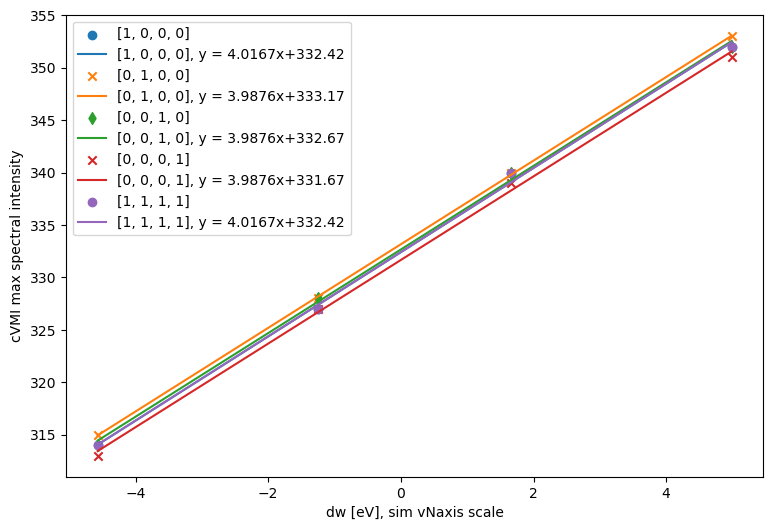

In [230]:
fig,axs = plt.subplots(figsize = (9,6))
plotstyle = ['o', 'x', 'd', 'x', 'o']
for j, qfilter in enumerate(quadrant_filters):
    plt.scatter(ees, rrs0[:,j], marker = plotstyle[j%5], label = qfilter)
    rplot = rrs0[:,j]
    eVplot = ees
    m,b = np.polyfit(eVplot,rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))
plt.xlabel('dw [eV], sim vNaxis scale')
plt.ylabel('cVMI max spectral intensity')
plt.legend()

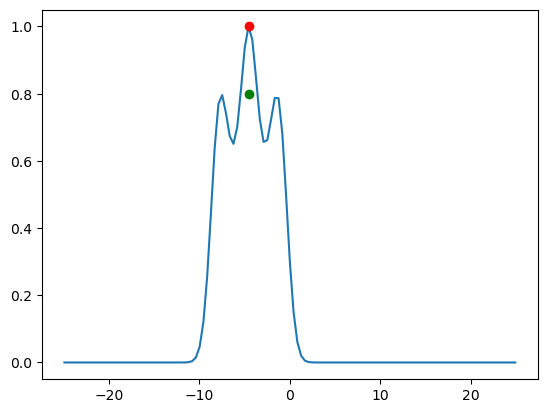

In [229]:
plt.plot(eV[1340:-1340],EwEw)
plt.plot(eV[1340:-1340][np.argmax(EwEw)], 1, 'ro')
plt.plot(eV[1340:-1340][get_centroidish(EwEw)],0.8, 'go')

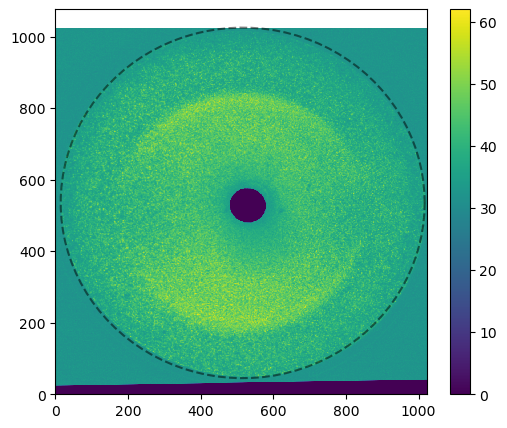

In [71]:
plt.figure(figsize=(6,5))
plt.pcolormesh(np.mean(imsM[0:10],0))
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(516+ 501*np.cos(phis), 535+ 490*np.sin(phis), 'k--', alpha = 0.5)
plt.colorbar()